# Problem Description:
Every day, we browse and buy things on Amazon, watch Netflix, listen to music on Spotify, and so on. For example, when you want to view a new movie, you normally ask your friends for recommendations; they are aware of your tastes and appropriately recommend a suitable film.
Because everyone has their unique preferences, it's impossible to keep track of each user's preferences manually.

# Business Understanding:
Companies have customised Recommendation Engines that offer things to you based on powerful algorithms...
Recommendation Systems are similar in that they are nothing more than data filtering tools that employ algorithms to recommend the most relevant items to a certain user.

The Internet is a vast ocean of information, with millions of goods and a massive product catalogue. Some Users know exactly what they want, while others have no idea what to look for in such a big collection of information, and this is where Recommendation Systems come in handy.

Some things may be excellent but have not attained **Popularity** due to a lack of advertising; recommendation systems aid in the popularity of such items by bringing them to the attention of the public.

**Ad Targeting** is also aided by it. Let's say you're trying to buy a new laptop on the Internet; your recent searches have yielded laptop recommendations, and you'll soon encounter adverts on websites offering laptop savings. So, Ad Targeting is an advertising method that uses specialised software and algorithms to display adverts automatically based on the user's recent searches.

According to a research published by the Network Advertising Initiative in 2009, ad targeting generated 2.7 times as much money as non-targeted ads.
As a result, it also aids the product's organisation in **increasing revenues**.

# File Ingestion and Schema Validation

In [1]:
%%writefile testutility_modcloth.py
import logging
import os
import subprocess
import yaml
import pandas as pd
import datetime 
import gc
import re

def read_yml_file(file_path):
    with open(file_path, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            logging.error(exc)

def replacer(string, char):
    pattern = char + '{2,}'
    string = re.sub(pattern, char, string)
    return string

def col_validate(df, col_config):
  cols = df.columns
  cols = cols.str.strip()
  cols.str.replace("_", "")
  cols = list(map(lambda x: replacer(x, ' '), list(cols)))
  expected_col = list(map(lambda x: x.lower(),  col_config['columns']))
  cols.sort()
  expected_col.sort()
  if len(cols) == len(expected_col) and cols == expected_col:
    print("Column name and Column length Validation Passed!!")
    return 1
  else:
    print("Column name and Column length Validation Failed..")
    mismatched_columns_file = list(set(cols).difference(expected_col))
    print("Following File columns are not in the YAML file", mismatched_columns_file)
    missing_YAML_file = list(set(expected_col).difference(cols))
    print("Following YAML columns are not in the file uploaded", missing_YAML_file)
    logging.info(f'df columns: {cols}')
    logging.info(f'expected columns: {expected_col}')
    return 0

# Function to get the size of dataset
def humanbytes(B):
  'Return the given bytes as a human friendly KB, MB, GB, or TB string'
  B = float(B)
  KB = float(1024)
  MB = float(KB ** 2) # 1,048,576
  GB = float(KB ** 3) # 1,073,741,824
  TB = float(KB ** 4) # 1,099,511,627,776

  if B < KB:
    return '{0} {1}'.format(B,'Bytes' if 0 == B > 1 else 'Byte')
  elif KB <= B < MB:
    return '{0:.2f} KB'.format(B/KB)
  elif MB <= B < GB:
    return '{0:.2f} MB'.format(B/MB)
  elif GB <= B < TB:
    return '{0:.2f} GB'.format(B/GB)
  elif TB <= B:
    return '{0:.2f} TB'.format(B/TB)

def stats(df, col_config):
  if col_validate(df, col_config) == 1:
    col_names = list(df.columns)
    no_of_cols = df.shape[1]
    no_of_rows = df.shape[0]
    size = df.memory_usage(deep=True).sum()
    file_size = humanbytes(size)
    statistics = f"\nNo. of Columns: {no_of_cols} \nNo. of Rows: {no_of_rows} \nColumn Names: {col_names} \nFile Size: {file_size}"
    print(statistics)

Writing testutility_modcloth.py


# Writing YAML File

In [2]:
%%writefile file_modcloth.yaml
columns: 
  - item_id
  - user_id
  - rating
  - timestamp
  - size
  - fit
  - user_attr
  - model_attr
  - category
  - brand
  - year
  - split
dataset_name: ModCloth
file_name: /content/drive/MyDrive/Kaggle/Capgemini/modcloth
file_type: csv
inbound_delimiter: ","
outbound_delimiter: "|"
skip_leading_rows: 1
table_name: ModCloth_Table

Writing file_modcloth.yaml


In [3]:
# Read config file
import testutility_modcloth as util
col_config = util.read_yml_file("file_modcloth.yaml")

#inspecting data of config file
col_config

{'columns': ['item_id',
  'user_id',
  'rating',
  'timestamp',
  'size',
  'fit',
  'user_attr',
  'model_attr',
  'category',
  'brand',
  'year',
  'split'],
 'dataset_name': 'ModCloth',
 'file_name': '/content/drive/MyDrive/Kaggle/Capgemini/modcloth',
 'file_type': 'csv',
 'inbound_delimiter': ',',
 'outbound_delimiter': '|',
 'skip_leading_rows': 1,
 'table_name': 'ModCloth_Table'}

In [4]:
# Read the file using yaml config file
file_type = col_config['file_type']
source_file = col_config['file_name'] + f'.{file_type}'
source_file

'/content/drive/MyDrive/Kaggle/Capgemini/modcloth.csv'

# Exploring the Dataset
The dataset I'm going to use is the ModCloth Dataset.
Let's have a look at the dataset.

## Importing the Libraries 

In [5]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math 
import itertools

# Modelling Helpers :
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score

# Evaluation metrics :
# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

# Deep Learning Libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

# Configure visualisations
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')
mpl.rcParams['font.size'] = 12
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['figure.facecolor'] = '#00000000'
%matplotlib inline

In [6]:
# Center all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");


# Make Visualizations better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 12,
    'figure.dpi': 150,
    'figure.figsize': [10, 6]
}
plt.rcParams.update(params)

## Extract Dataset

In [7]:
# read the file using config file

m = pd.read_csv(source_file, delimiter=col_config['inbound_delimiter'])
m.head()

,item_id,user_id,rating,timestamp,size,fit,user_attr,model_attr,category,brand,year,split
0,7443,Alex,4,2010-01-21 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0
1,7443,carolyn.agan,3,2010-01-27 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,2012,0
2,7443,Robyn,4,2010-01-29 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0
3,7443,De,4,2010-02-13 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,2012,0
4,7443,tasha,4,2010-02-18 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,2012,0


The dataset has 12 columns.
* **item_id** - Every item is represented by an unique Id.
* **user_id** - Every user is represented by an uniue Id.
* **rating** - Represents the rating given by the user to the corresponding item.
* **timestamp** - The time at which the rating was recorded.

In [8]:
# Validating Input File
if util.col_validate(m, col_config) == 0:
    print("Validation Failed!!")
else:
    print("Column Validation Passed..")

Column name and Column length Validation Passed!!
Column Validation Passed..


In [9]:
# Getting the size of the dataset
size = m.memory_usage(deep=True).sum()
file_size = util.humanbytes(size)
print(file_size)

45.64 MB


In [10]:
# Getting some stats
util.stats(m, col_config)

Column name and Column length Validation Passed!!

No. of Columns: 12 
No. of Rows: 99893 
Column Names: ['item_id', 'user_id', 'rating', 'timestamp', 'size', 'fit', 'user_attr', 'model_attr', 'category', 'brand', 'year', 'split'] 
File Size: 45.64 MB


In [11]:
m.shape

(99893, 12)

In [12]:
m.describe()

,item_id,rating,size,year,split
count,99893.000000,99893.000000,78133.000000,99893.000000,99893.000000
mean,83944.091208,4.209594,3.217322,2015.476450,0.358564
std,43558.135979,1.080633,1.885934,1.970262,0.720993
min,6454.000000,1.000000,0.000000,2010.000000,0.000000
25%,48629.000000,4.000000,2.000000,2014.000000,0.000000
50%,77878.000000,5.000000,3.000000,2016.000000,0.000000
75%,120126.000000,5.000000,4.000000,2017.000000,0.000000
max,155950.000000,5.000000,8.000000,2019.000000,2.000000


Some insights that can be drawn are:

1. The minimum rating given to the item is 1.0 whereas the maximum rating given to the item is 5.0
2. The items have item_id's in the range 6454 - 155950.( Note that 155950 is the highest item_id and not total number of items. )

# Visualizing the Data

## Heavily Rated Items

In [13]:
df_n_ratings = pd.DataFrame(m.groupby('item_id')['rating'].mean())
df_n_ratings['total ratings'] = pd.DataFrame(m.groupby('item_id')['rating'].count())
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
item_id,,
34935,4.482247,1887
21296,4.171760,1636
32405,4.325829,1599
32406,4.328648,1494
32403,4.367199,1378
67507,3.963154,1357
16411,3.668254,1260
55967,4.260309,1164
57369,3.701677,1133


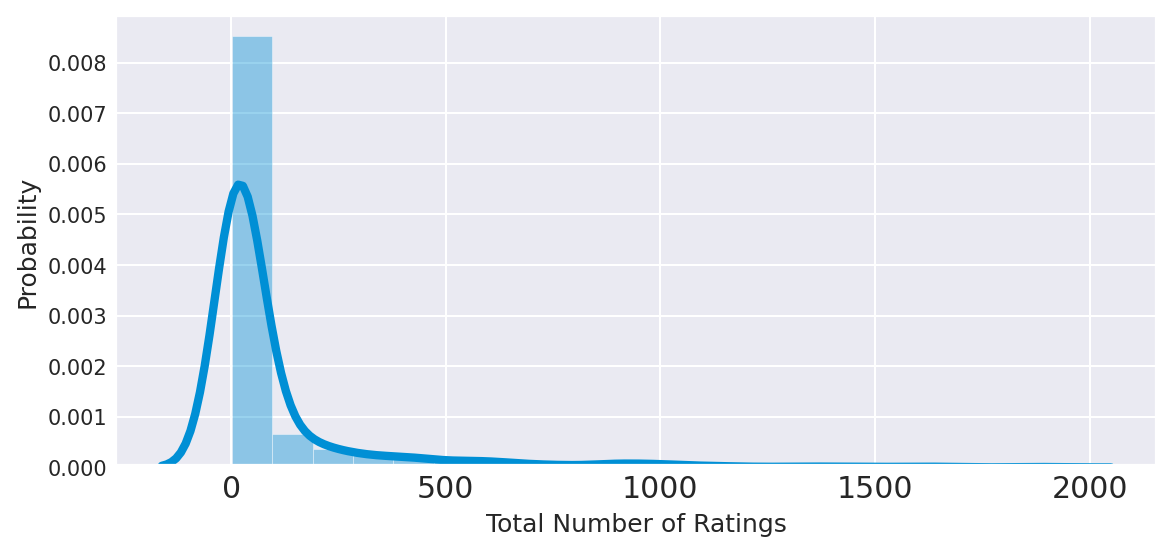

In [14]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

We can see that - 
* Majority of the items have less than 100 ratings.
* The number of items having more than 500 ratings is very low.

## Highly Rated Items

In [15]:
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
item_id,,
152834,5.0,3
153536,5.0,5
153196,5.0,8
148277,5.0,1
153131,5.0,7
151458,5.0,1
153543,5.0,7
154928,5.0,3
153350,5.0,5


In [16]:
print('Total no of items that were rated 5.0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')
print('Total no of individual users that gave rating of 5.0 : ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5) & (df_n_ratings['total ratings'] == 1)]))

Total no of items that were rated 5.0 :  14 

Total no of individual users that gave rating of 5.0 :  4


It is clear that very few items got the perfect rating of 5.0 but there are only 4 unique users who have given the rating of 5.0

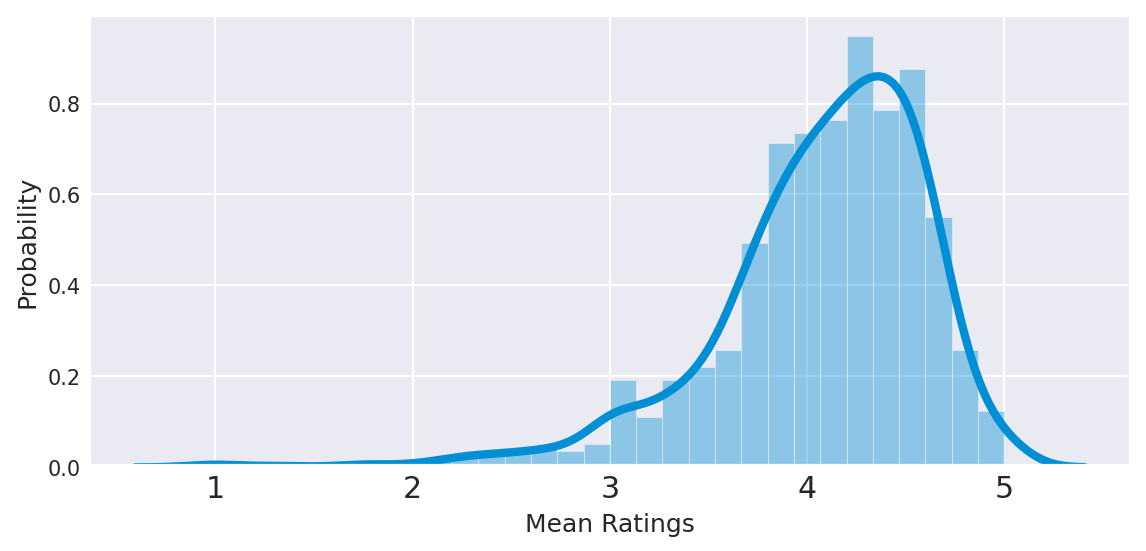

In [17]:
plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['mean ratings'], bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

## Mean Ratings vs Total Number of Ratings

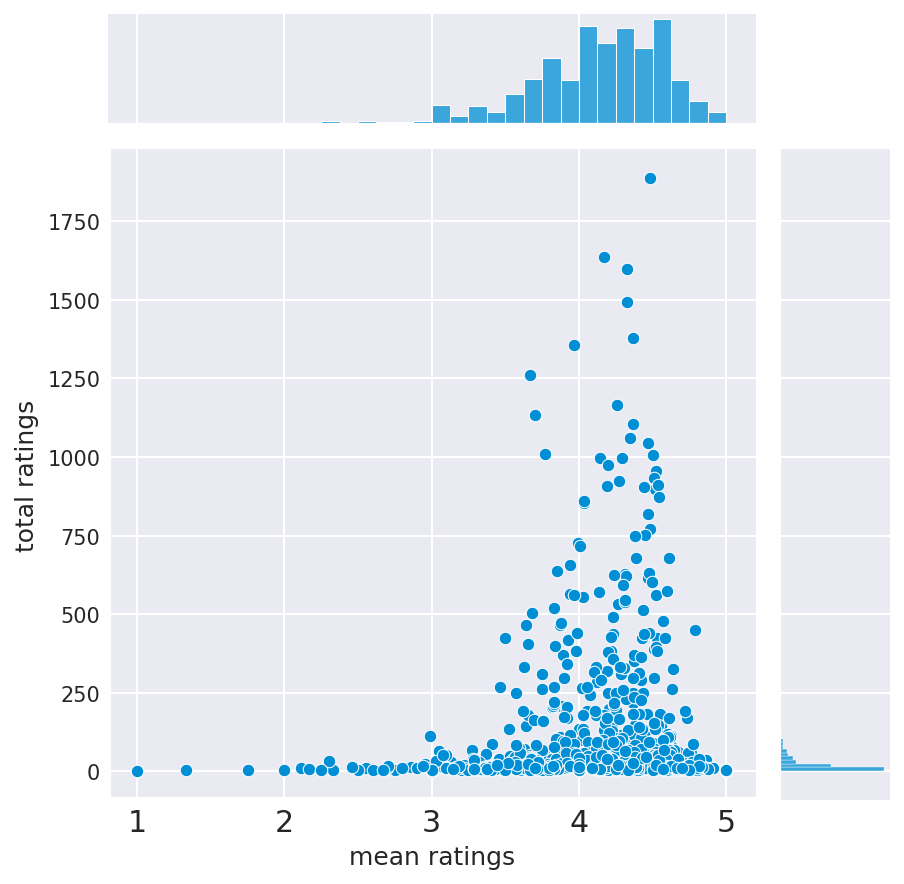

In [18]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings )

* Here, every Data Point represents a distinct Item, with y-coordinate representing the total no of users which has rated that item and x-coordinate representing the mean of all the ratings of the corresponding users.
* Also there is a huge Density in the region corresponding between mean rating 3-5 .

In [19]:
m['timestamp'] = pd.to_datetime(m['timestamp'])
m['Day'] = m['timestamp'].dt.day
m['Weekday'] = m['timestamp'].dt.weekday
m['Month'] = m['timestamp'].dt.month
m['Year'] = m['timestamp'].dt.year

m.drop('year', axis=1, inplace=True)

In [20]:
m.sort_values(by='timestamp', inplace=True)
m.head()

,item_id,user_id,rating,timestamp,size,fit,user_attr,model_attr,category,brand,split,Day,Weekday,Month,Year
0,7443,Alex,4,2010-01-21 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,0,21,3,1,2010
1,7443,carolyn.agan,3,2010-01-27 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,0,27,2,1,2010
2,7443,Robyn,4,2010-01-29 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,0,29,4,1,2010
3,7443,De,4,2010-02-13 08:00:00+00:00,NaN,NaN,NaN,Small,Dresses,NaN,0,13,5,2,2010
4,7443,tasha,4,2010-02-18 08:00:00+00:00,NaN,NaN,Small,Small,Dresses,NaN,0,18,3,2,2010


In [21]:
m.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99893 entries, 0 to 99892
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   item_id     99893 non-null  int64              
 1   user_id     99892 non-null  object             
 2   rating      99893 non-null  int64              
 3   timestamp   99893 non-null  datetime64[ns, UTC]
 4   size        78133 non-null  float64            
 5   fit         81387 non-null  object             
 6   user_attr   91526 non-null  object             
 7   model_attr  99893 non-null  object             
 8   category    99893 non-null  object             
 9   brand       25913 non-null  object             
 10  split       99893 non-null  int64              
 11  Day         99893 non-null  int64              
 12  Weekday     99893 non-null  int64              
 13  Month       99893 non-null  int64              
 14  Year        99893 non-null  int64     

## Check Duplicate Rows if any

In [22]:
duplicate = m[m.duplicated()]
duplicate

,item_id,user_id,rating,timestamp,size,fit,user_attr,model_attr,category,brand,split,Day,Weekday,Month,Year


There are no duplicate rows!

## Checking Null values

In [23]:
m.isna().sum()

item_id           0
user_id           1
rating            0
timestamp         0
size          21760
fit           18506
user_attr      8367
model_attr        0
category          0
brand         73980
split             0
Day               0
Weekday           0
Month             0
Year              0
dtype: int64

In [24]:
# Dropping a row having null value in column 'user_id'
m = m[m['user_id'].notna()]
m.isna().sum()

item_id           0
user_id           0
rating            0
timestamp         0
size          21760
fit           18505
user_attr      8367
model_attr        0
category          0
brand         73980
split             0
Day               0
Weekday           0
Month             0
Year              0
dtype: int64

In [25]:
# Dropping all null values & saving it in a new variable
m2 = m.dropna()
m2.isna().sum()

item_id       0
user_id       0
rating        0
timestamp     0
size          0
fit           0
user_attr     0
model_attr    0
category      0
brand         0
split         0
Day           0
Weekday       0
Month         0
Year          0
dtype: int64

In [26]:
m2.shape

(15430, 15)

## Find unique values of each column

In [27]:
m2.nunique()

item_id         509
user_id       10860
rating            5
timestamp      2793
size              9
fit               5
user_attr         2
model_attr        2
category          4
brand            31
split             3
Day              31
Weekday           7
Month            12
Year              9
dtype: int64

There are 509 different items,
10860 different users,
9 different sizes,
5 different fit,
and so on..

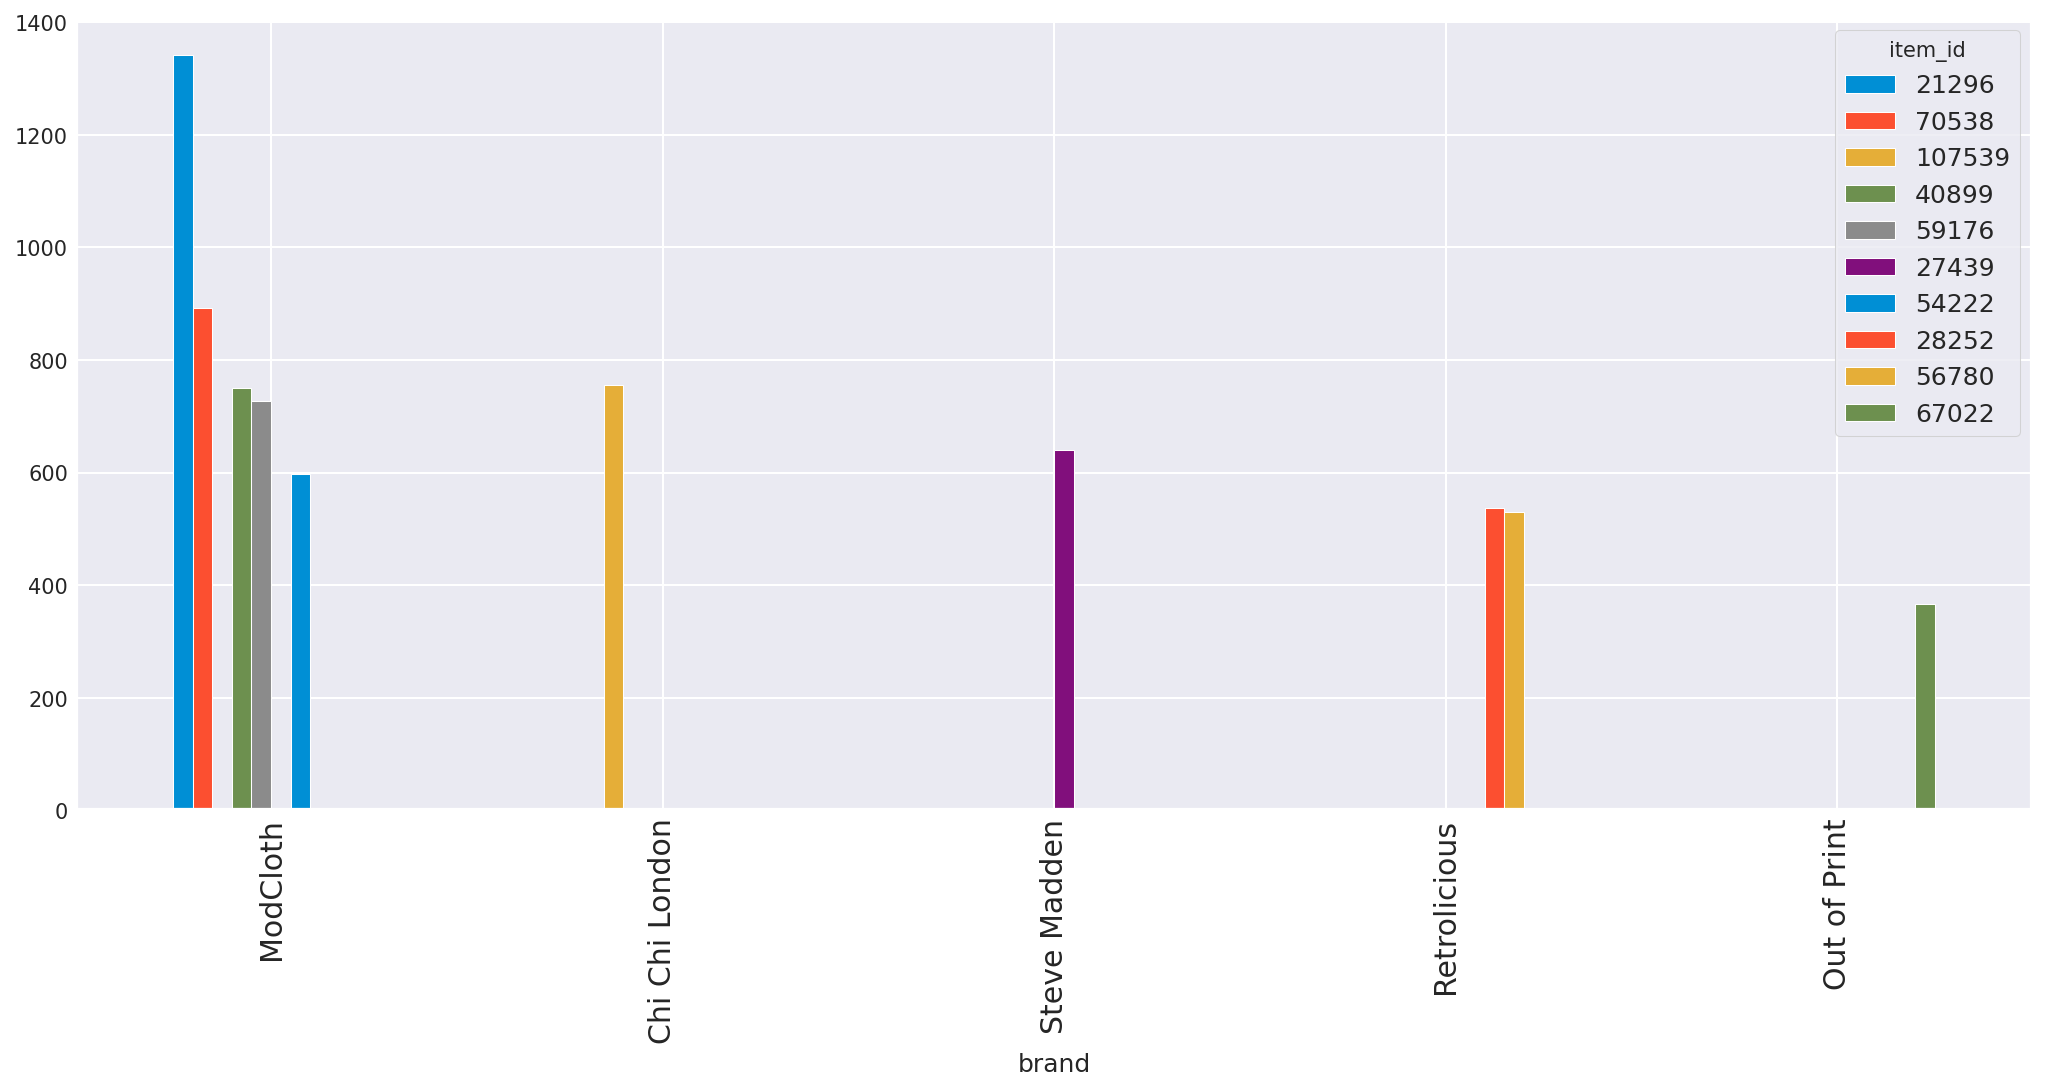

In [28]:
brand_grp = m2.groupby('brand')

brand_grp['item_id'].value_counts().nlargest(10).unstack().plot(kind='bar', figsize=(15, 7));

From the above graph, it can be infered that brand 'ModCloth' has a total of 5 out of Top 10 selling items.

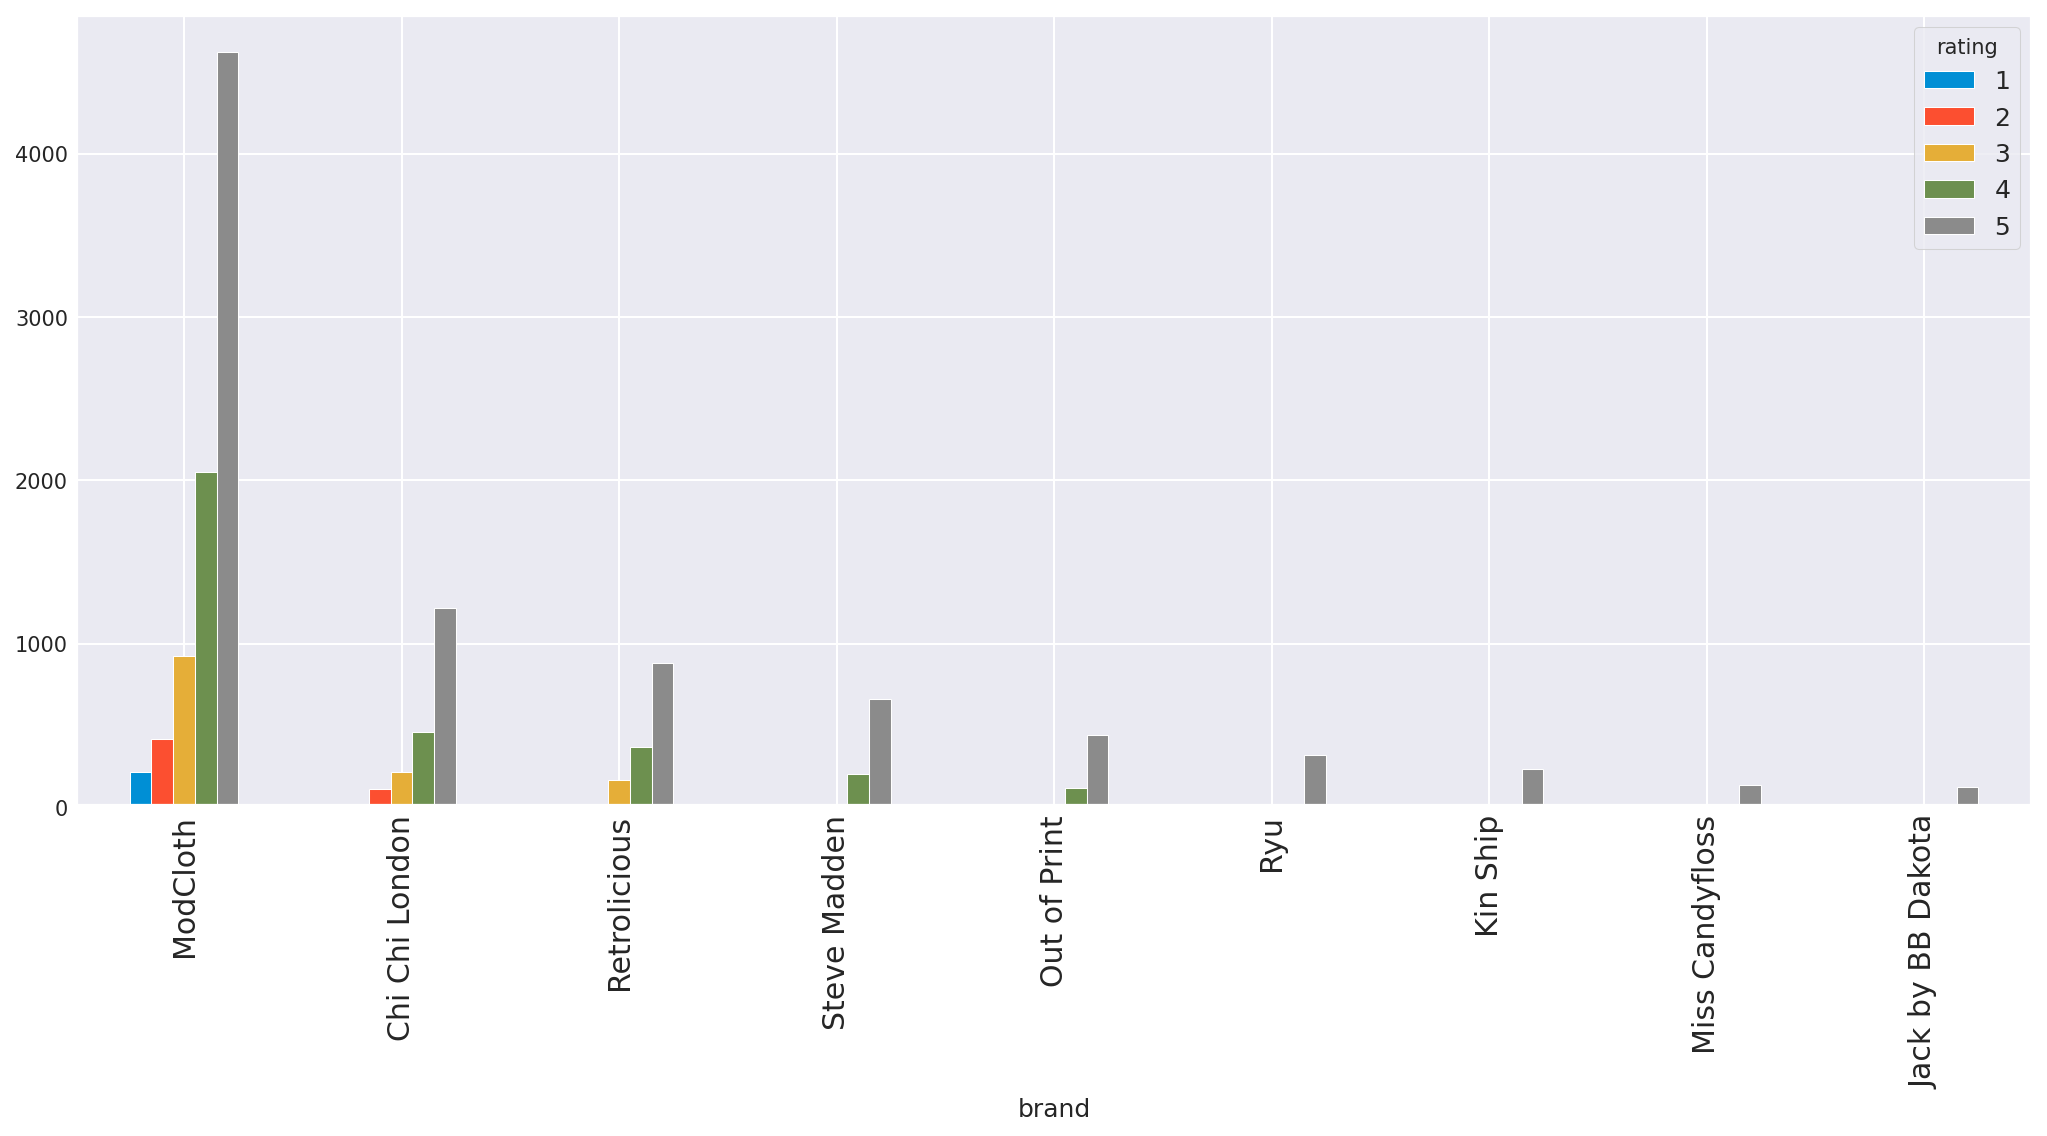

In [29]:
brand_grp['rating'].value_counts().nlargest(20).unstack().plot(kind='bar', figsize=(15, 7));

For these top selling brands rating of '5' is given the most.

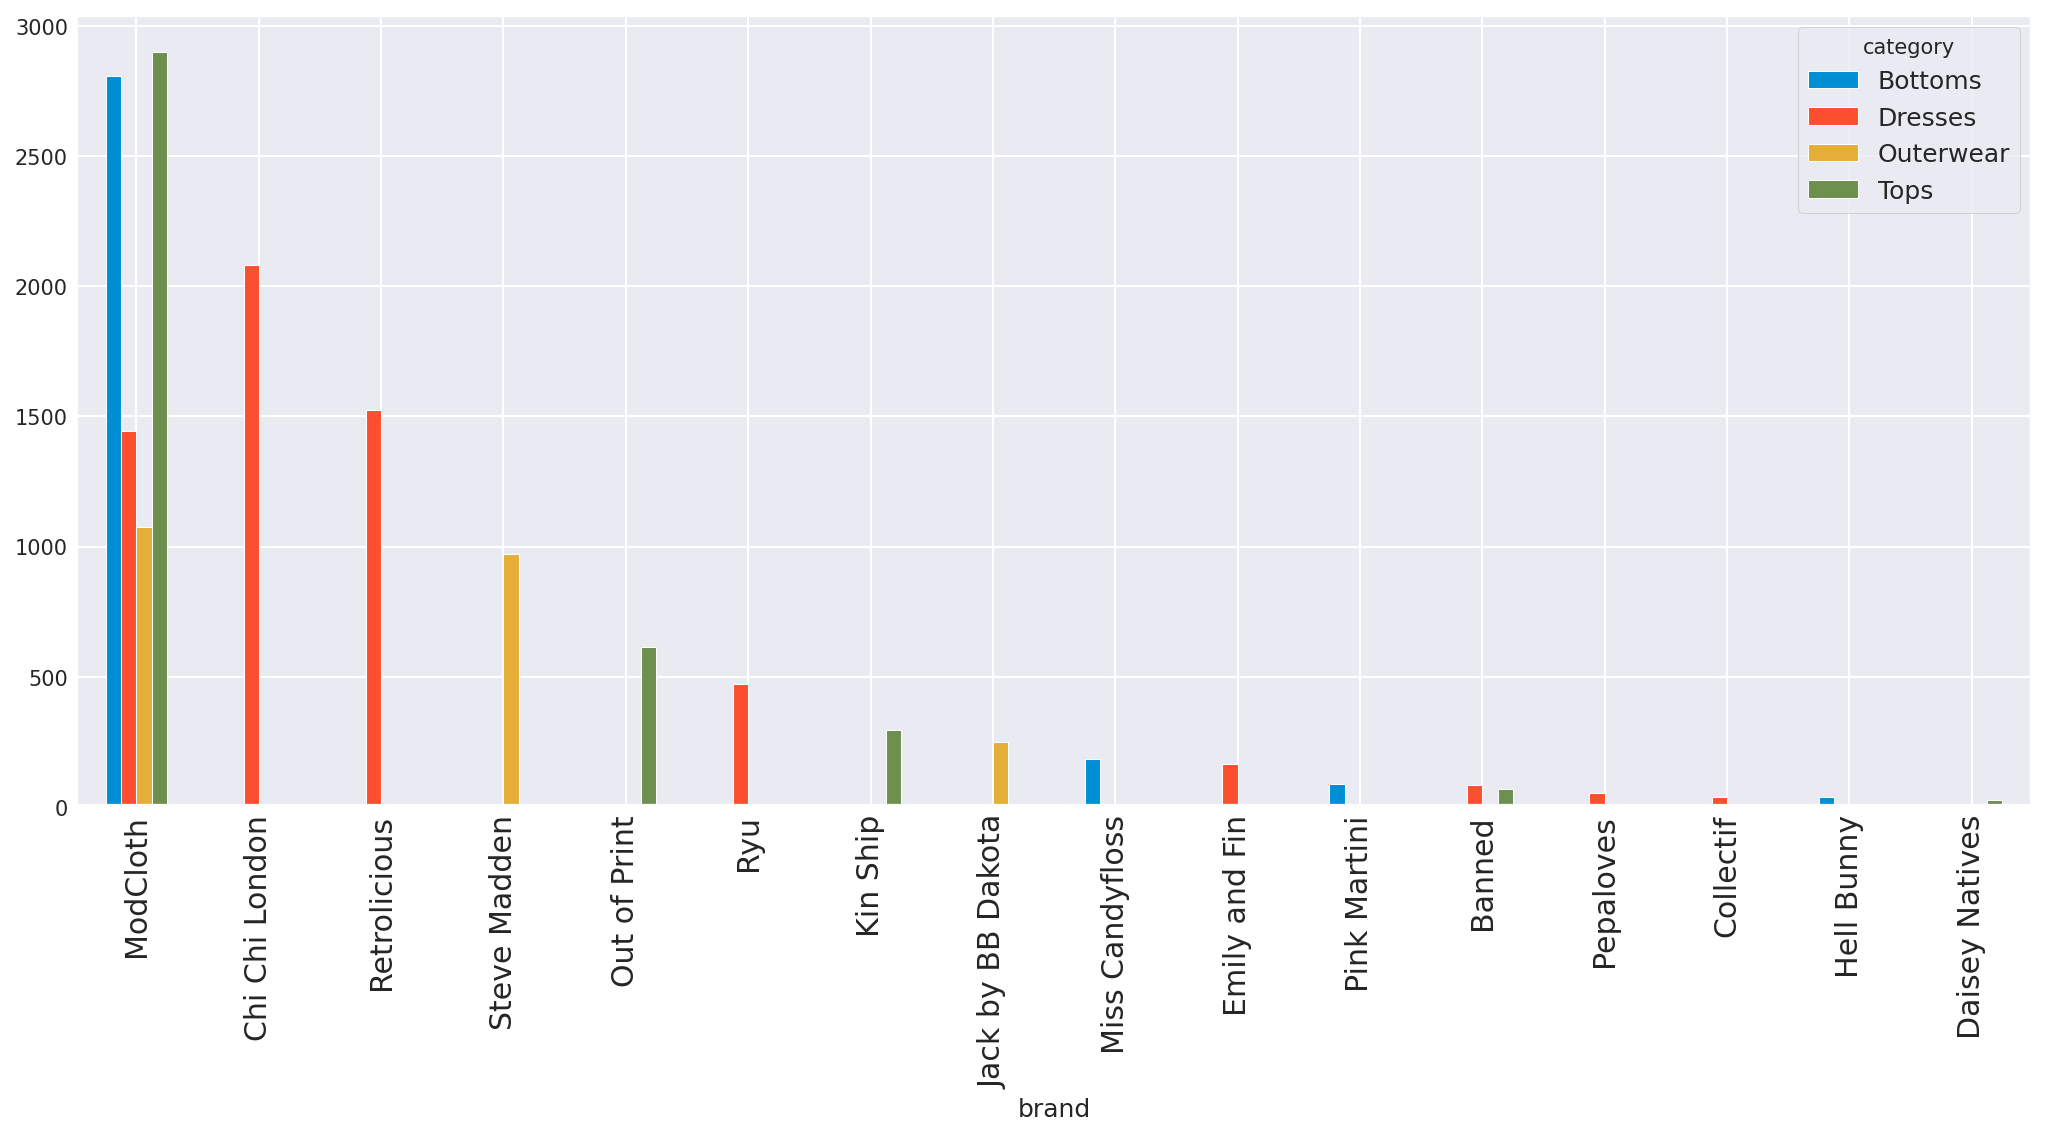

In [30]:
brand_grp['category'].value_counts().nlargest(20).unstack().plot(kind='bar', figsize=(15, 7));

It is clear that the brand 'ModCloth' is dominating the market in all 4 categories.

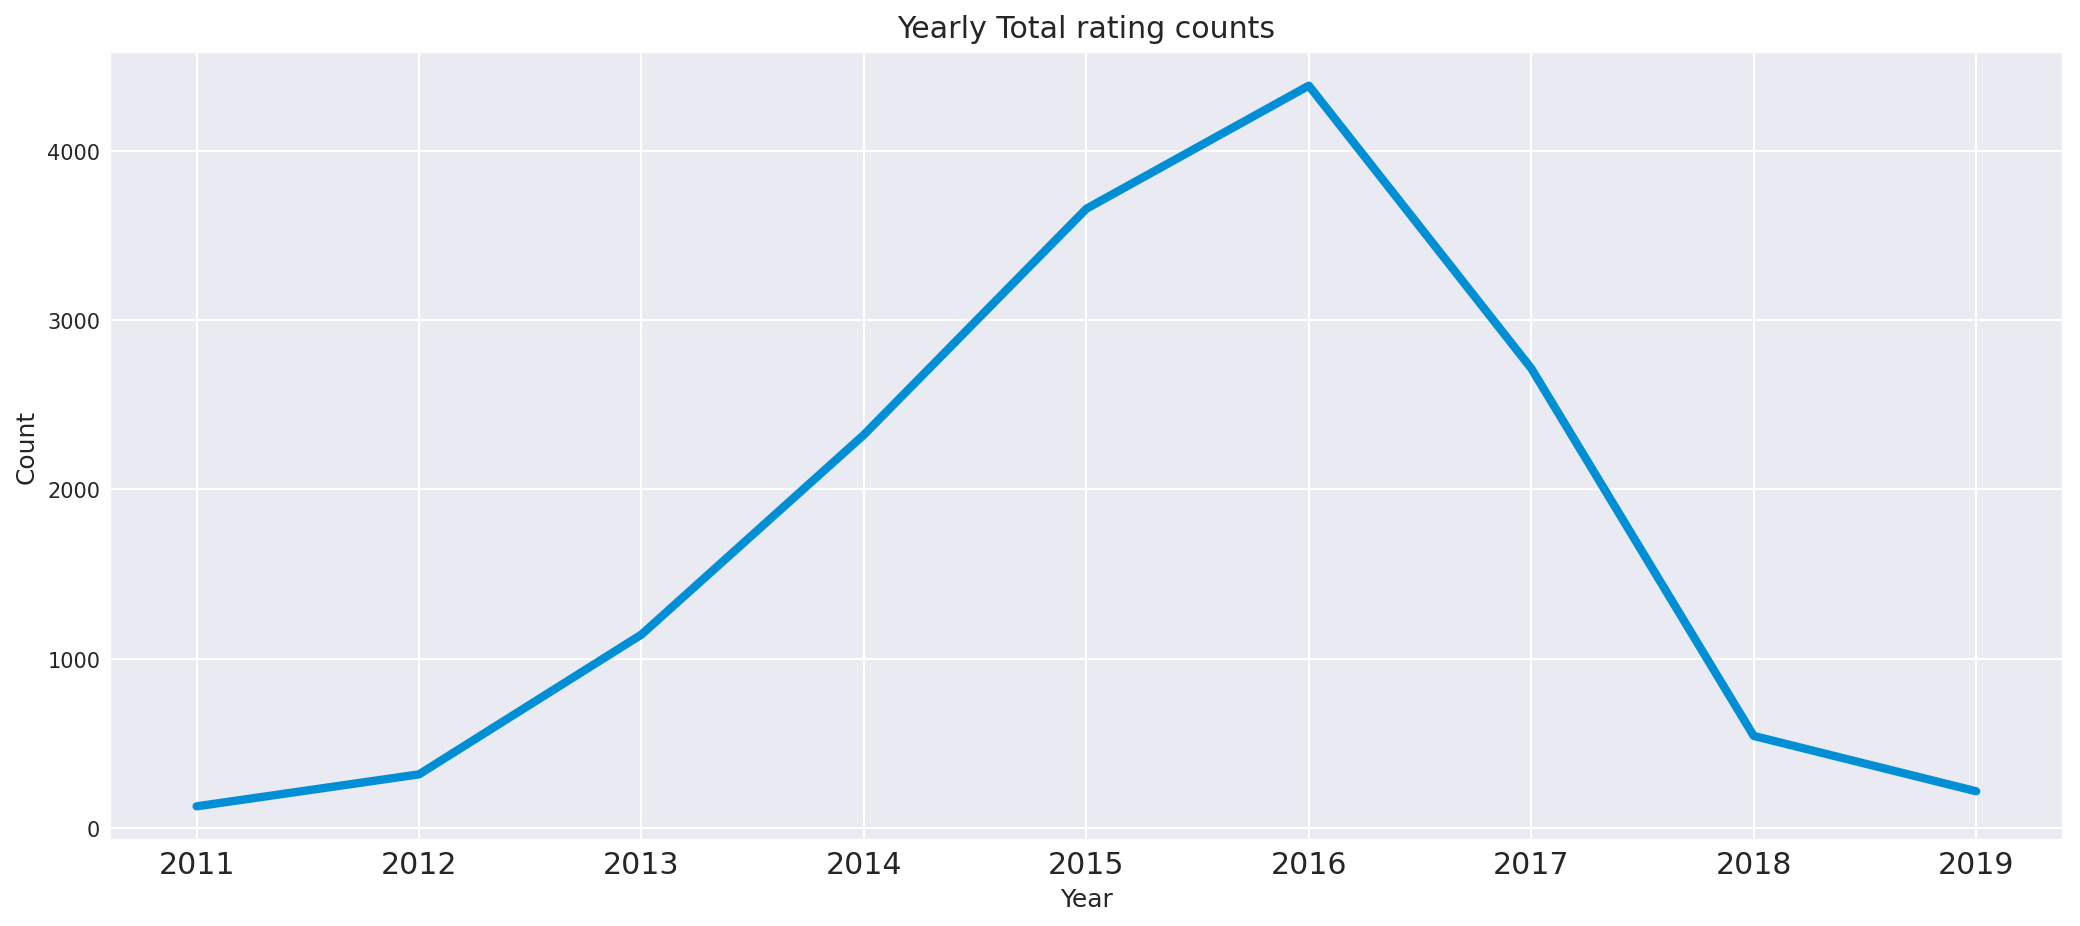

In [31]:
plt.figure(figsize=(15,7))
m2.groupby('Year')['rating'].count().plot(kind='line');
plt.title('Yearly Total rating counts')
plt.ylabel('Count')
plt.show()

Highest number of ratings was given in the year 2016

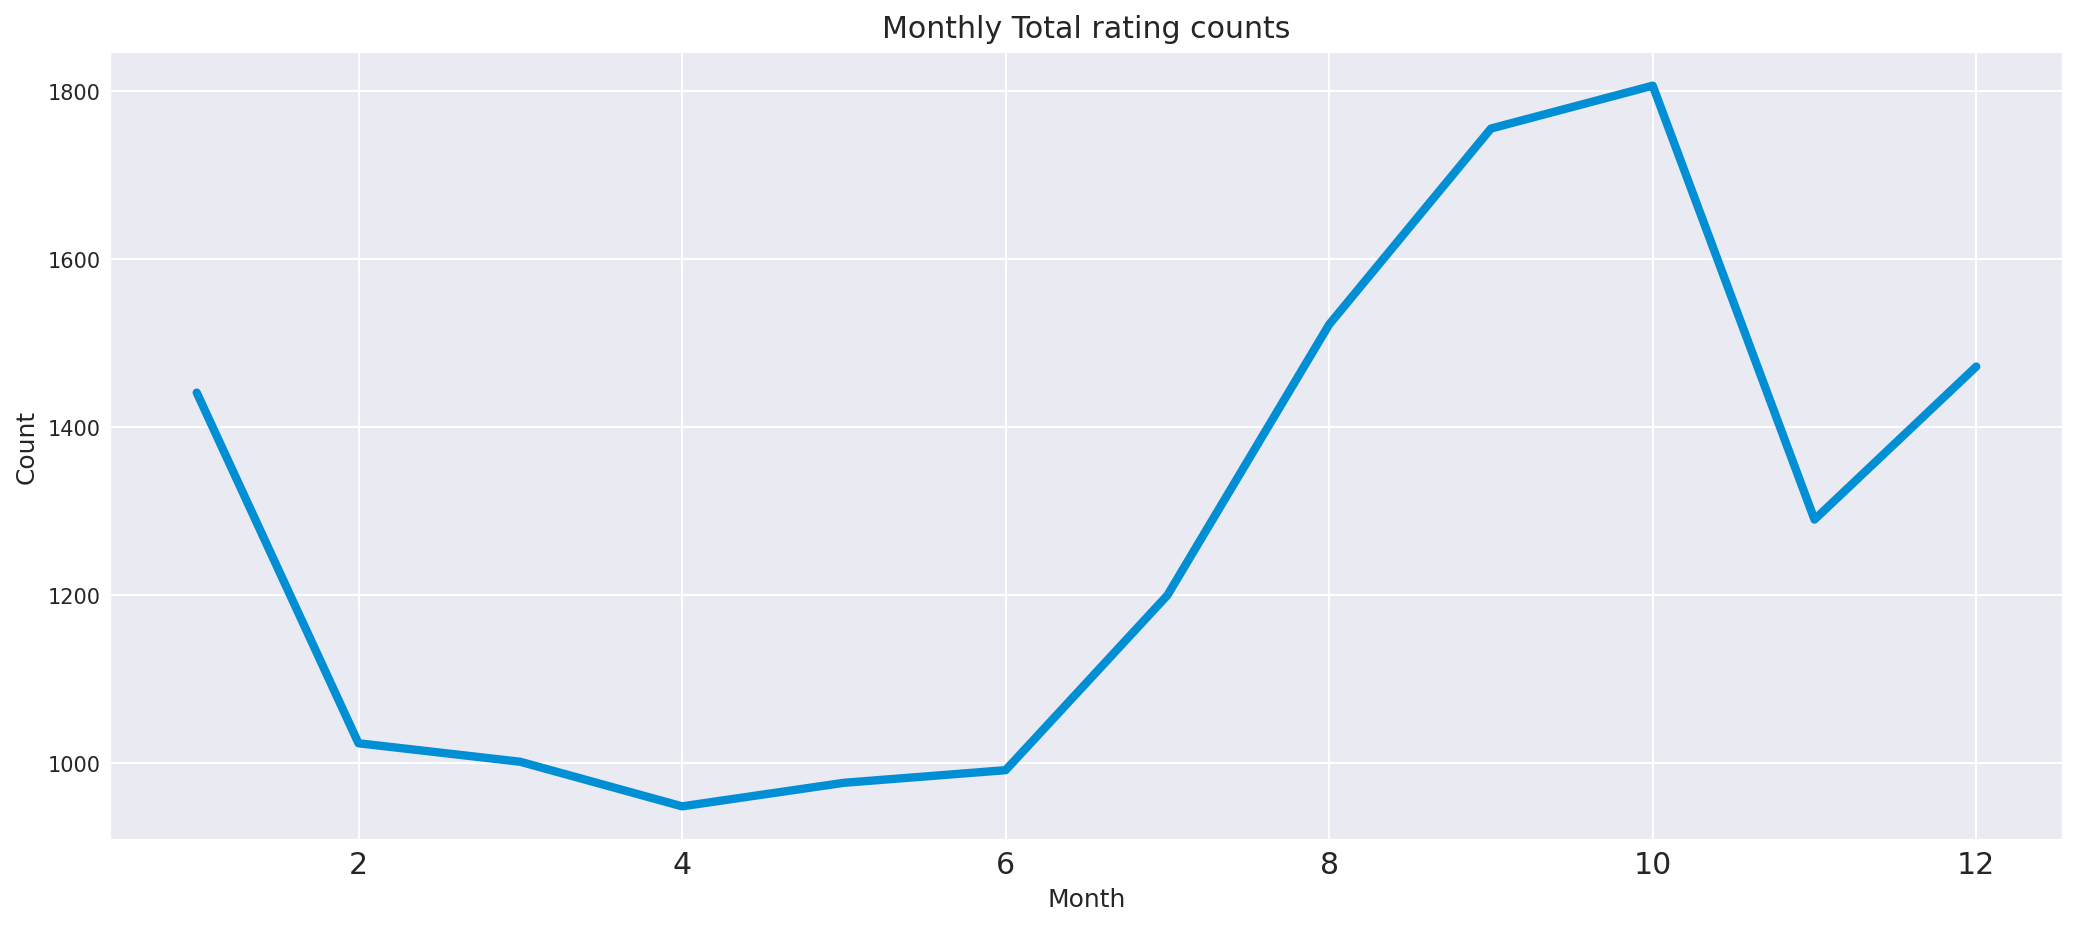

In [32]:
plt.figure(figsize=(15,7))
m2.groupby('Month')['rating'].count().plot(kind='line');
plt.title('Monthly Total rating counts')
plt.ylabel('Count')
plt.show()

During July - October there is a drastic decrease in the number of ratings given by the users.

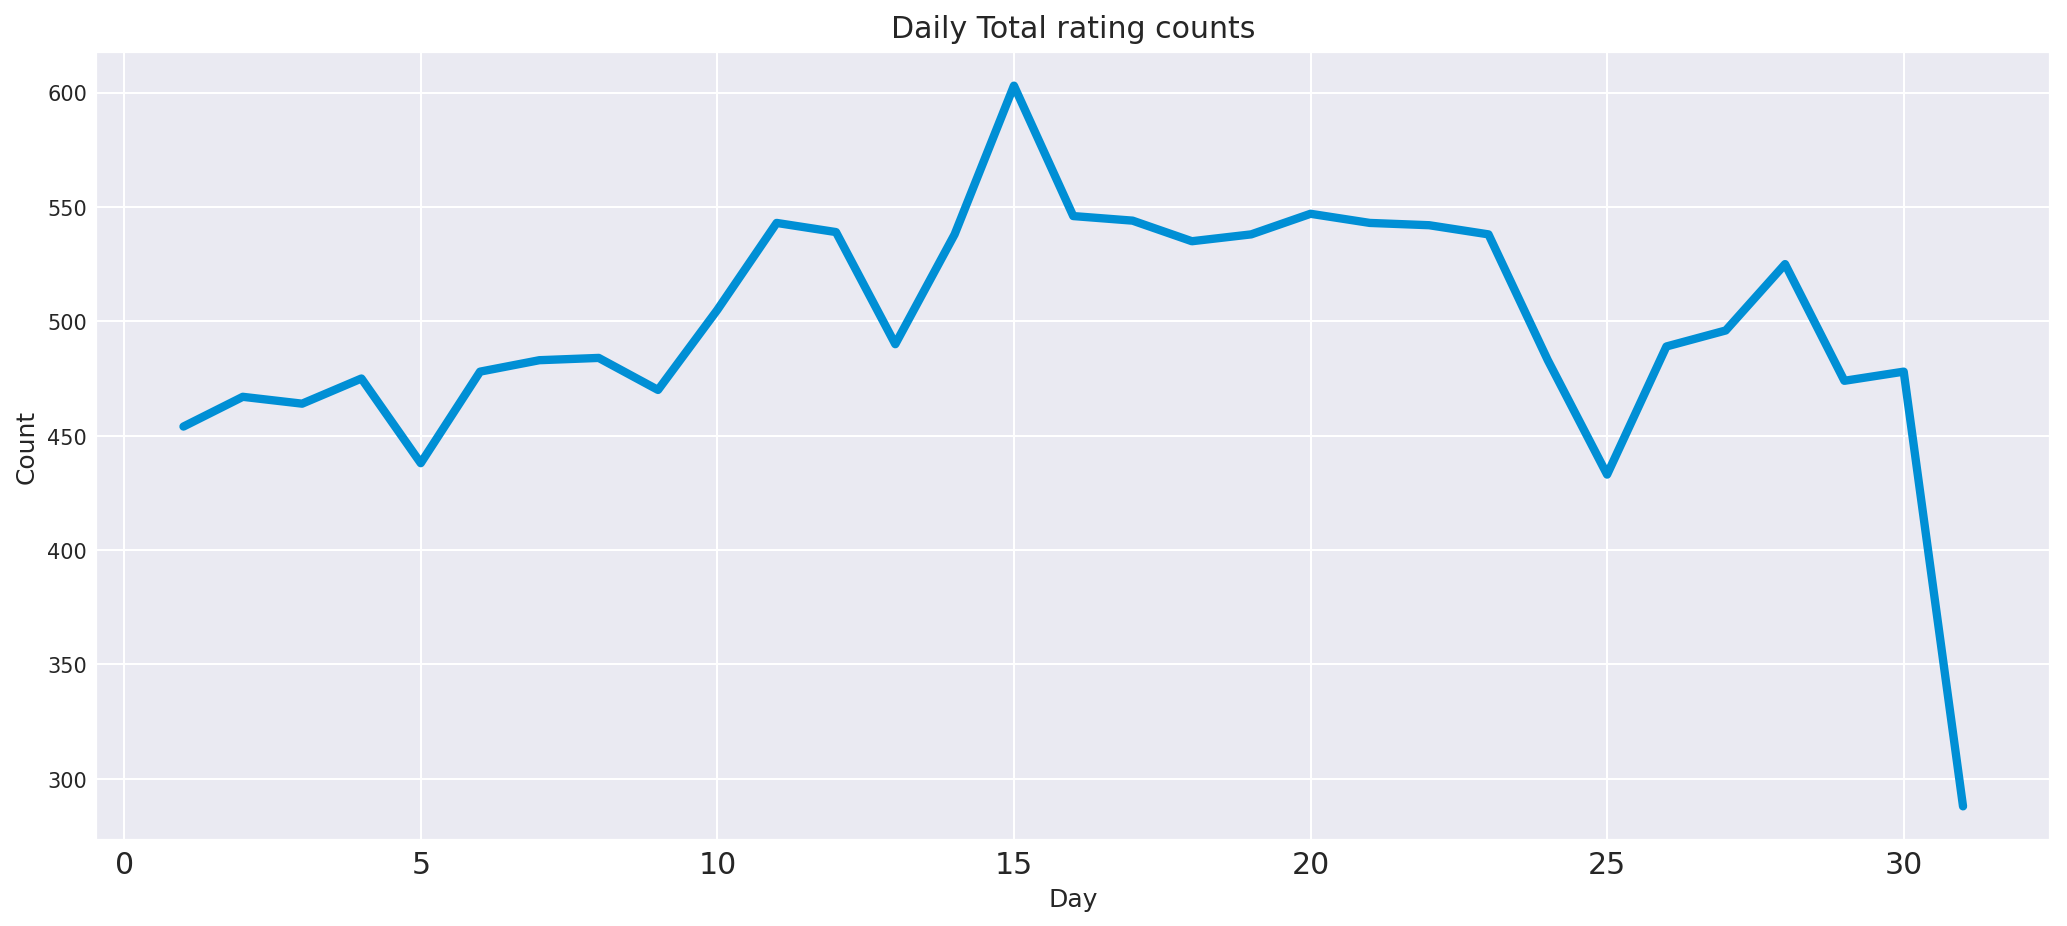

In [33]:
plt.figure(figsize=(15,7))
m2.groupby('Day')['rating'].count().plot(kind='line');
plt.title('Daily Total rating counts')
plt.ylabel('Count')
plt.show()

We can see that the ratings count is more towards the mid of a month only.

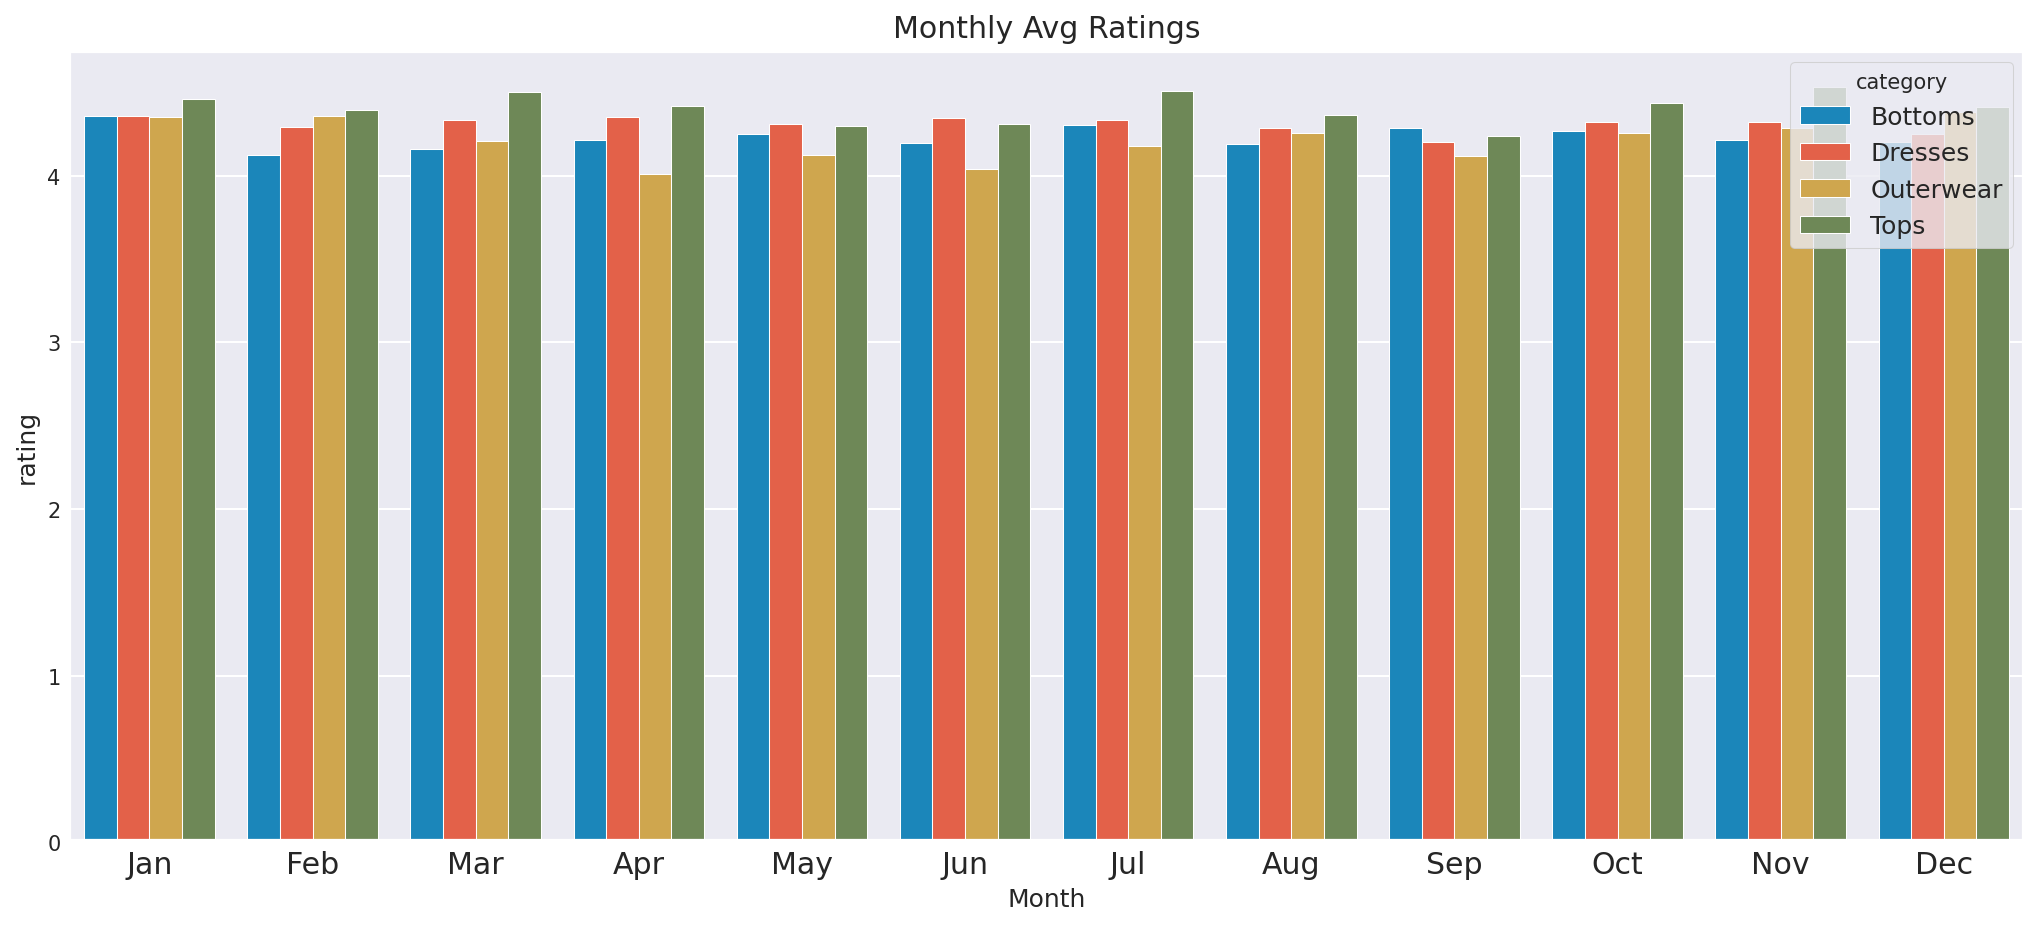

In [34]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(15,7))
g = sns.barplot('Month', 'rating', data=m2, hue='category', ci=None);
g.set_xticklabels(labels=month, rotation=0)
g.set_title('Monthly Avg Ratings')
plt.show()

Monthly ratings remains more or less constant.

Tops are the high-rated item throughout.

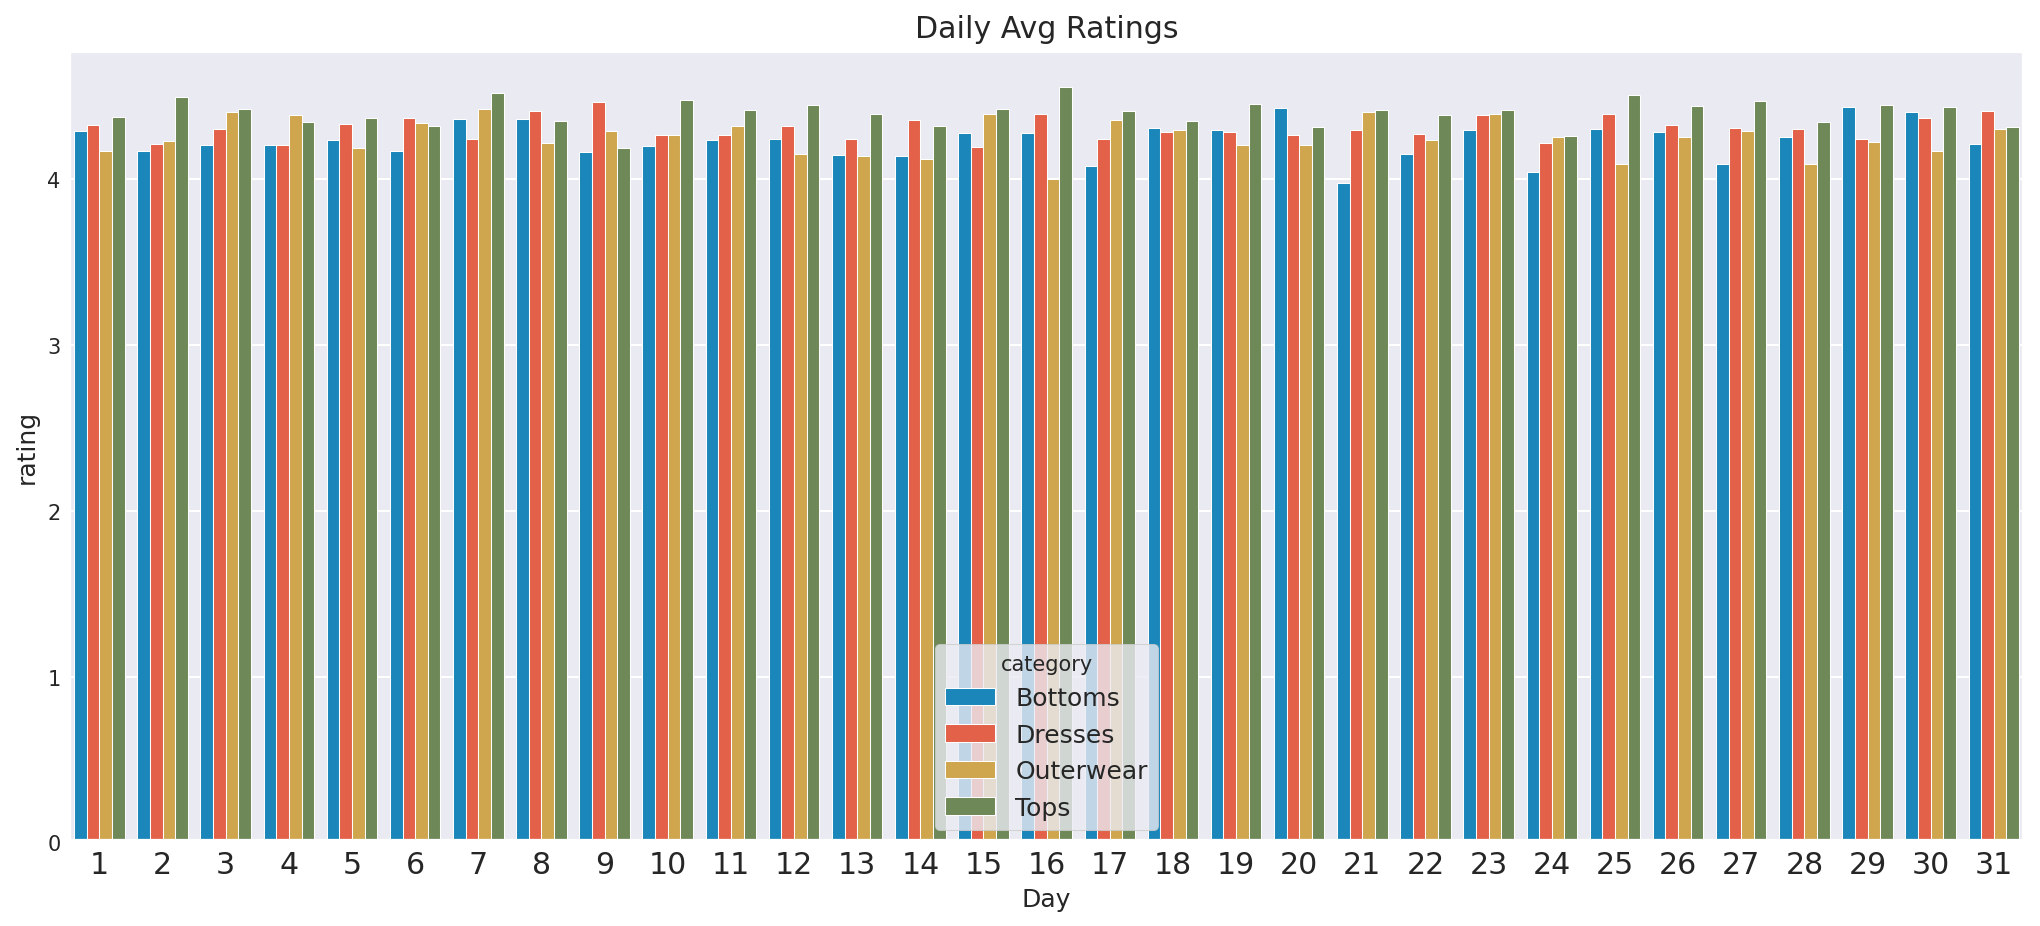

In [35]:
plt.figure(figsize=(15,7))
g = sns.barplot('Day', 'rating', data=m2, hue='category', ci=None);
g.set_title('Daily Avg Ratings')
plt.show()

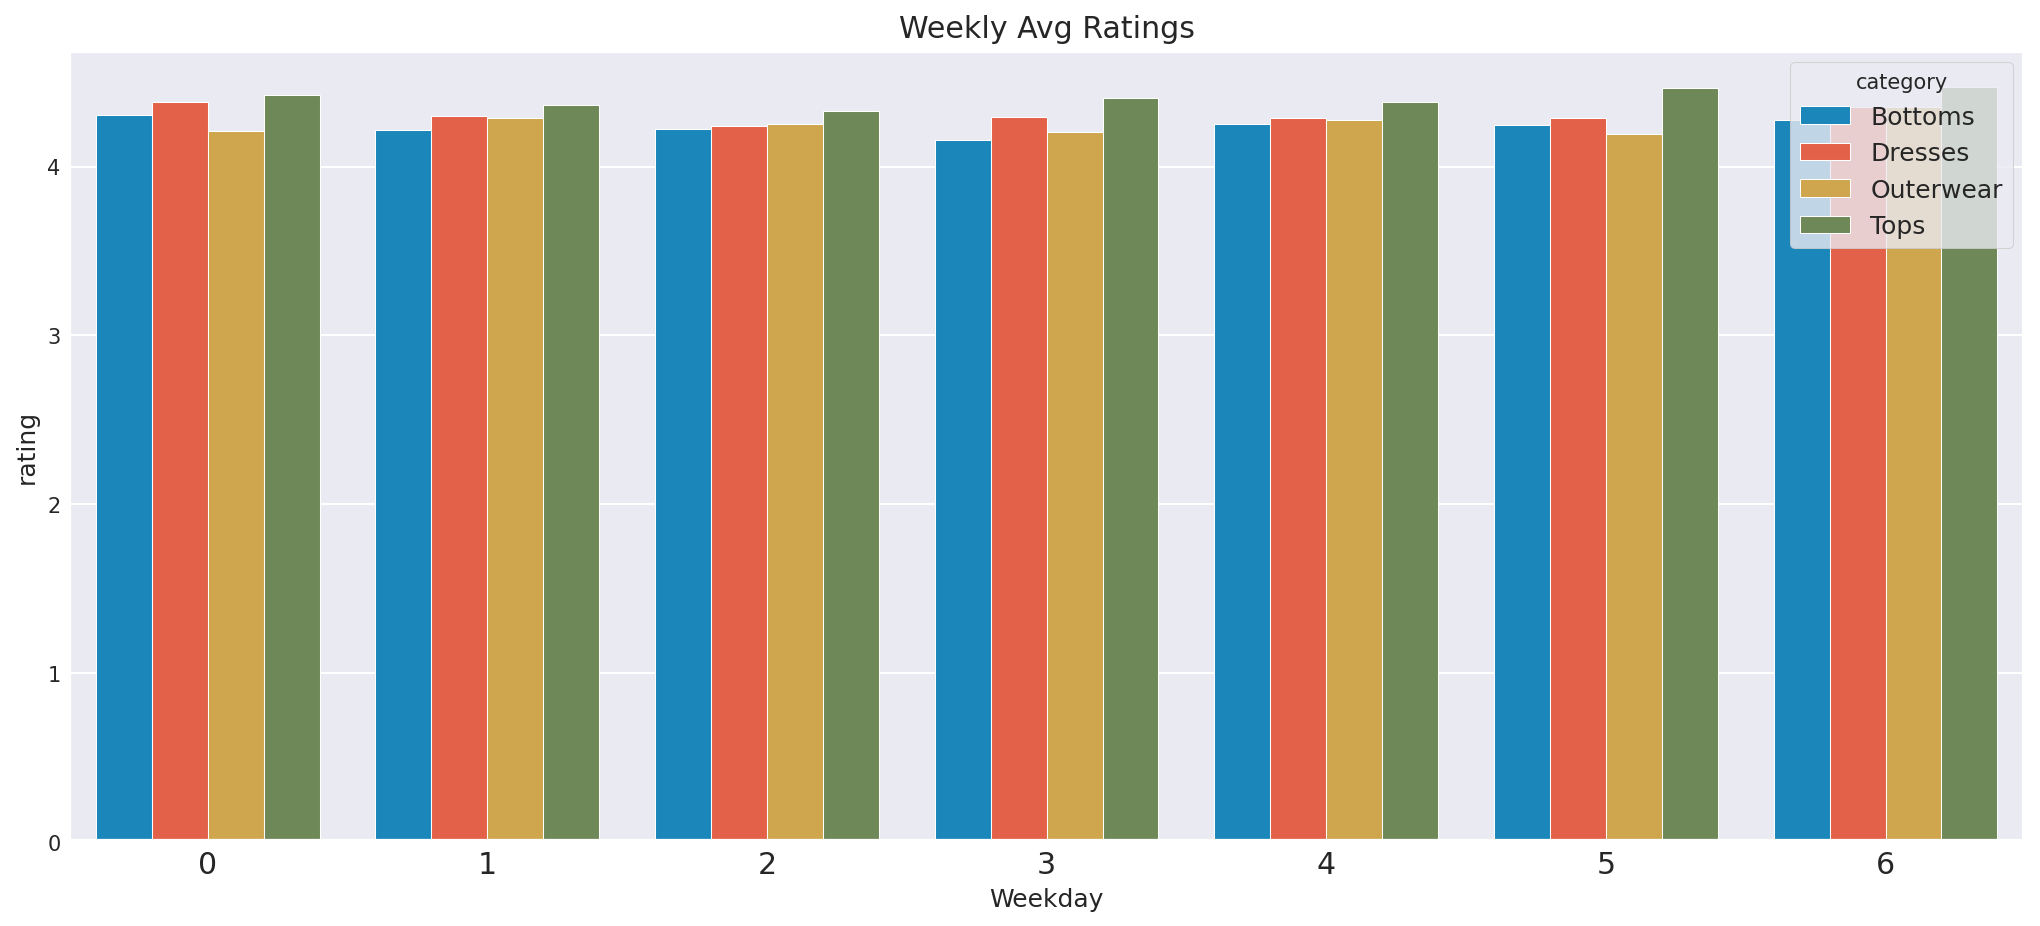

In [36]:
plt.figure(figsize=(15,7))
g = sns.barplot('Weekday', 'rating', data=m2, hue='category', ci=None);
g.set_title('Weekly Avg Ratings')
plt.show()

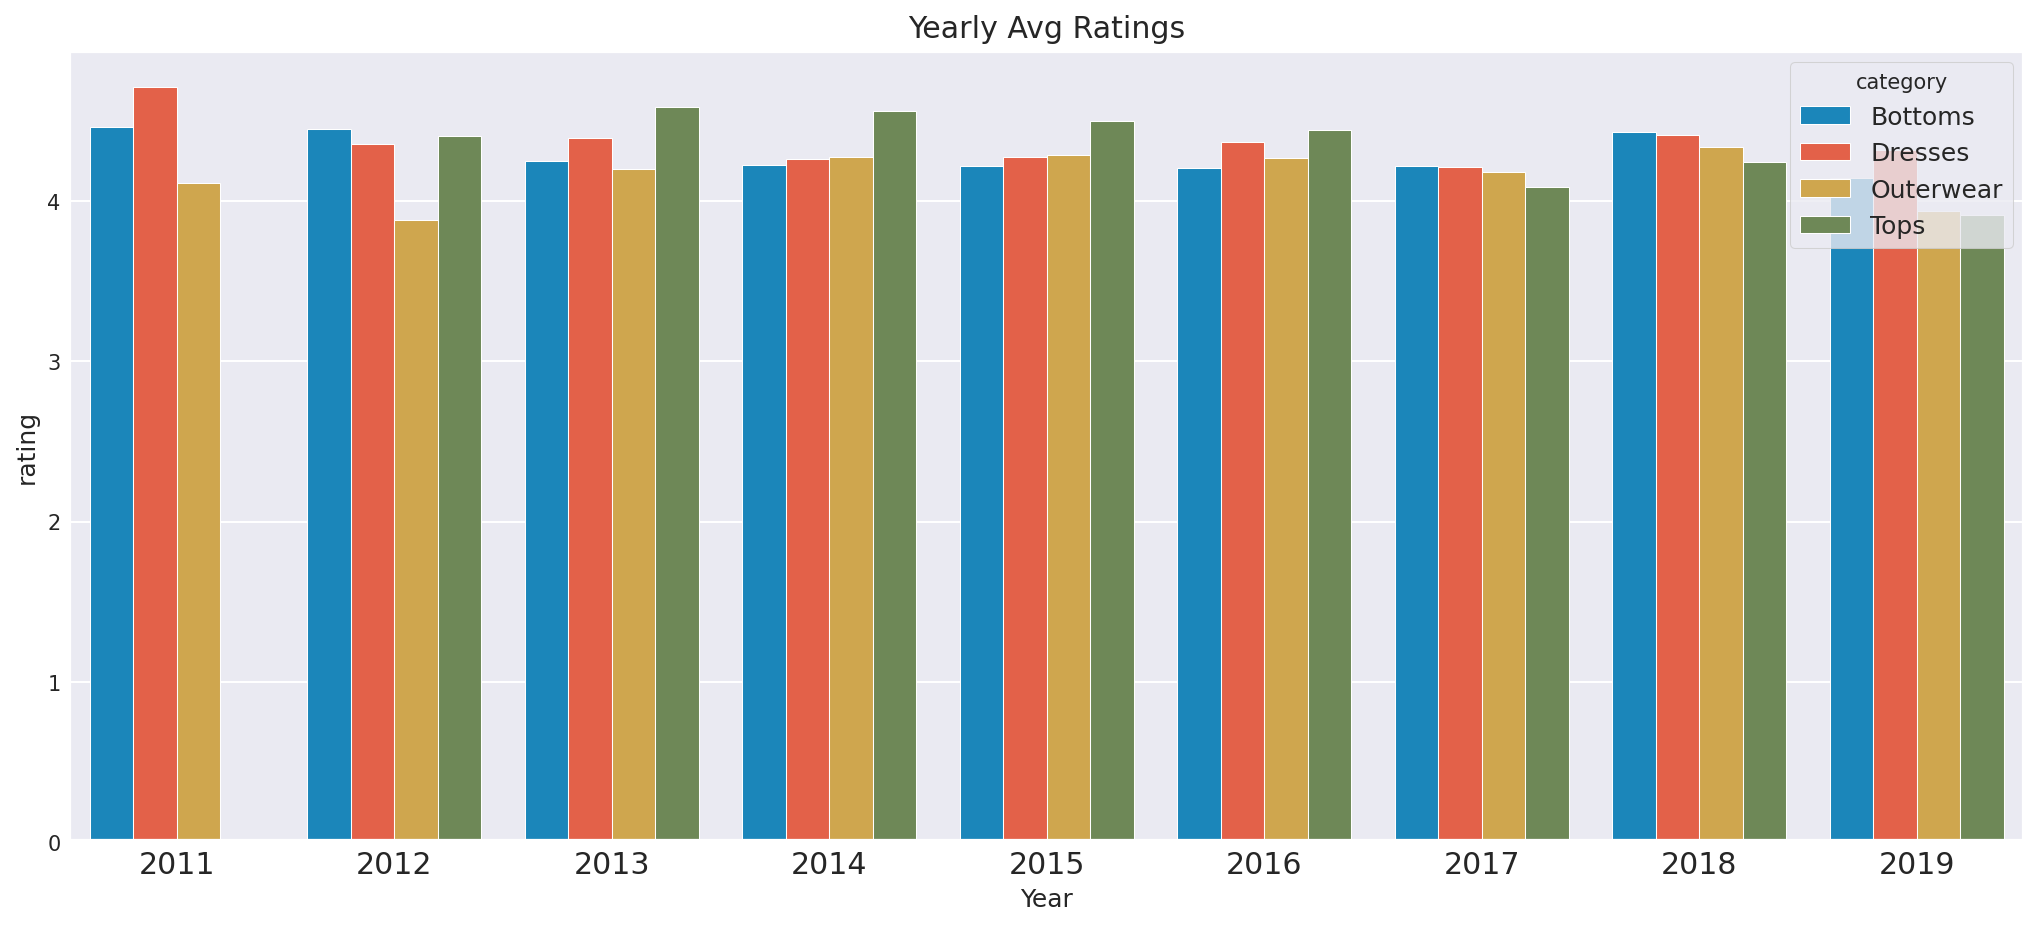

In [37]:
plt.figure(figsize=(15,7))
g = sns.barplot('Year', 'rating', data=m2, hue='category', ci=None);
g.set_title('Yearly Avg Ratings')
plt.show()

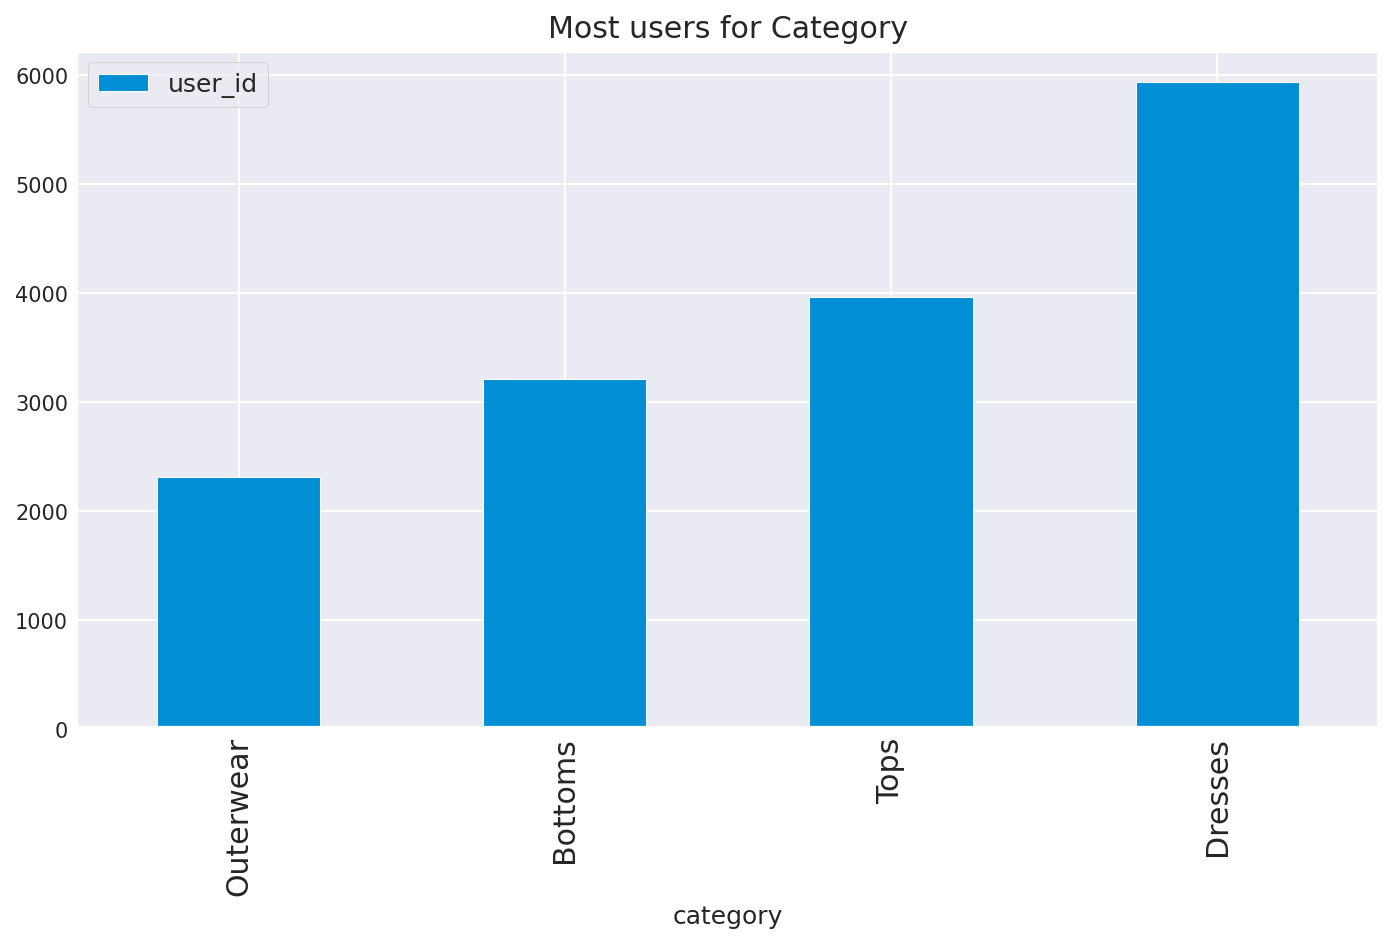

In [38]:
cat = pd.DataFrame(m2.groupby('category')['user_id'].count().sort_values(ascending=True))
cat[:5].plot(kind='bar', title='Most users for Category')

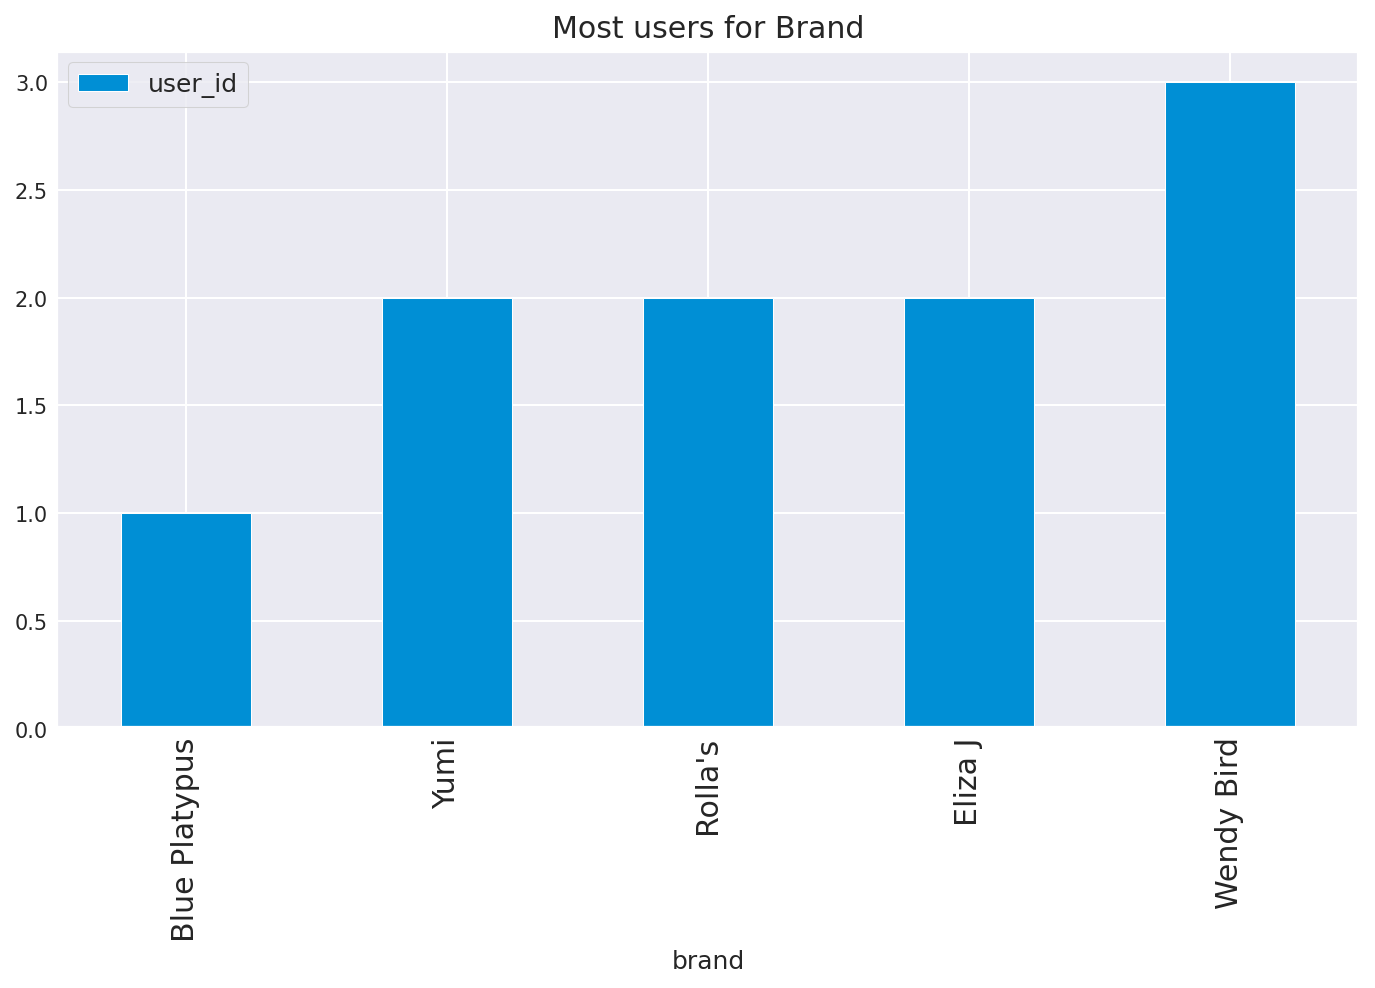

In [39]:
br = pd.DataFrame(m2.groupby('brand')['user_id'].count().sort_values(ascending=True))
br[:5].plot(kind='bar', title='Most users for Brand')

##T Test
A t-test is a type of inferential statistic which is used to determine if there is a significant difference between the means of two groups which may be related in certain features

T-test has 2 types :
1. One sampled t-test
2. Two-sampled t-test.

In [40]:
import scipy.stats as stat
from scipy.stats import ttest_1samp
from scipy.stats import ttest_ind

In [41]:
sample_size = int((10/100)*359392) # Considering 10% values as sample data

def T_Test(a, b):
    sample_a = np.random.choice(a, sample_size)
    sample_b = np.random.choice(b, sample_size)
    ttest, p_value = ttest_ind(sample_a, sample_b, equal_var = False)
    print(f'p-value: {p_value}')
    if p_value < 0.05:    # alpha value is 0.05 or 5%
        print("We are rejecting null hypothesis (H0)")
    else:
        print("We are accepting null hypothesis (H0)")

### H0 = Brand 'Wendy Bird' is not sold more than the brand 'Eliza J'
### H1 = Brand 'Wendy Bird' is sold more than the brand 'Eliza J'

In [42]:
T_Test(m2[m2['brand'] == 'Wendy Bird'].count(), m2[m2['brand'] == 'Eliza J'].count())

p-value: 0.0
We are rejecting null hypothesis (H0)


### H0 = Brand 'Wendy Bird' is not sold more than the brand 'Rolla's'
### H1 = Brand 'Wendy Bird' is sold more than the brand 'Rolla's'

In [43]:
T_Test(m2[m2['brand'] == 'Wendy Bird'].count(), m2[m2['brand'] == "Rolla's"].count())

p-value: 0.0
We are rejecting null hypothesis (H0)


### H0 = Tops are in more demand than Dresses
### H1 = Dresses are in more demand than Tops

In [44]:
T_Test(m2[m2['category'] == 'Dresses']['user_id'].count(), m2[m2['category'] == 'Tops']['user_id'].count())

p-value: 0.0
We are rejecting null hypothesis (H0)


## Chi2 Test

In [45]:
def check_relationship(crosstab_table, confidence_interval):
  statistic, p, dof, expected = stat.chi2_contingency(crosstab_table)
  print(f'Chi2 statistic value = {statistic}')
  print(f'p - value = {p}')
  print("Degree of Freedom: ", dof)
  alpha = 1.0 - confidence_interval

  if p <= alpha:
    print('Dependent, Reject Null Hypothesis (H0)')
  else:
    print('Independent, Accept Null Hypothesis (H0)')

### H0: There is no Brand preference towards a category
### H1: There is Brand preference towards a category

In [46]:
# Contingency Table
ct = pd.crosstab(m2['category'], m2['brand'])
ct

brand,Alice's Pig,BB Dakota,Banned,Blue Platypus,Chi Chi London,Closet London,Collectif,Compania Fantastica,Daisey Natives,Effie's Heart,Eliza J,Emily and Fin,Hell Bunny,Jack by BB Dakota,Kin Ship,Louche,Mata Traders,Miss Candyfloss,Miss Patina,ModCloth,Out of Print,Pepaloves,Pink Martini,Retrolicious,Rolla's,Ryu,Steve Madden,Sugarhill Boutique,Wendy Bird,Wrangler,Yumi
category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Bottoms,8,1,16,0,0,0,22,3,0,0,0,0,37,0,0,3,0,186,0,2808,0,4,89,9,2,0,0,0,0,24,0
Dresses,0,3,83,0,2080,7,37,10,0,3,2,166,26,5,0,0,4,0,4,1443,0,53,0,1523,0,471,0,11,3,0,2
Outerwear,0,0,0,0,0,0,3,0,0,0,0,0,3,251,0,0,0,0,2,1074,0,0,0,0,0,0,972,0,0,9,0
Tops,0,0,70,1,0,0,18,8,28,0,0,0,20,0,294,0,0,0,0,2900,613,0,0,2,0,0,0,9,0,5,0


In [47]:
check_relationship(ct, 0.95)

Chi2 statistic value = 19665.219635782112
p - value = 0.0
Degree of Freedom:  90
Dependent, Reject Null Hypothesis (H0)


### H0: There is no relationship between Brand and Item
### H1: There is relationship between Brand and Item


In [48]:
# Contingency Table
ct = pd.crosstab(m2['item_id'], m2['brand'])
ct

brand,Alice's Pig,BB Dakota,Banned,Blue Platypus,Chi Chi London,Closet London,Collectif,Compania Fantastica,Daisey Natives,Effie's Heart,Eliza J,Emily and Fin,Hell Bunny,Jack by BB Dakota,Kin Ship,Louche,Mata Traders,Miss Candyfloss,Miss Patina,ModCloth,Out of Print,Pepaloves,Pink Martini,Retrolicious,Rolla's,Ryu,Steve Madden,Sugarhill Boutique,Wendy Bird,Wrangler,Yumi
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6454,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0
21296,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1341,0,0,0,0,0,0,0,0,0,0,0
27439,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,641,0,0,0,0
28252,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,537,0,0,0,0,0,0,0
35525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,261,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
154749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
154934,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
check_relationship(ct, 0.95)

Chi2 statistic value = 462900.0
p - value = 0.0
Degree of Freedom:  15240
Dependent, Reject Null Hypothesis (H0)


### H0: There is no relationship between weekday and category
### H1: There is relationship between weekday and category

In [50]:
# Contingency Table
ct = pd.crosstab(m2['Weekday'], m2['category'])
ct

category,Bottoms,Dresses,Outerwear,Tops
Weekday,,,,
0,404,875,304,532
1,462,878,322,551
2,526,844,344,586
3,462,889,353,579
4,519,838,336,604
5,443,801,338,563
6,396,811,317,553


In [51]:
check_relationship(ct, 0.95)

Chi2 statistic value = 29.822330139720346
p - value = 0.0392100473266992
Degree of Freedom:  18
Dependent, Reject Null Hypothesis (H0)


# Data Cleaning before building Recommendation System

In [52]:
m.isna().sum()

item_id           0
user_id           0
rating            0
timestamp         0
size          21760
fit           18505
user_attr      8367
model_attr        0
category          0
brand         73980
split             0
Day               0
Weekday           0
Month             0
Year              0
dtype: int64

In [53]:
m.drop(['timestamp', 'size', 'fit', 'user_attr', 'model_attr', 'category', 'brand', 'split', 'Day', 'Weekday', 'Month', 'Year'], axis=1, inplace=True)
m.head()

,item_id,user_id,rating
0,7443,Alex,4
1,7443,carolyn.agan,3
2,7443,Robyn,4
3,7443,De,4
4,7443,tasha,4


In [54]:
m.shape

(99892, 3)

### Removing all users who have rated < 5 items.

In [55]:
m = m.groupby('user_id').filter(lambda x: len(x) >= 5)
m.shape

(40411, 3)

## Model-based collaborative filtering system
Utility Matrix based on products sold and user reviews

Utility Matrix : An utlity matrix is consists of all possible user-item preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all teh items in the list, hence, most of the values are unknown.

In [56]:
ratings_utility_matrix = m.pivot_table(values='rating', index='user_id', columns='item_id', fill_value=0)
ratings_utility_matrix.head()

item_id,6454,7443,11960,16411,21296,22563,24853,27439,27590,28252,28967,31644,31752,32134,32236,32403,32405,32406,34931,34935,34937,35272,35525,36172,36408,40141,40899,44261,44893,47325,47397,47657,48629,49525,49587,50405,50818,52406,54062,54222,...,154473,154505,154518,154537,154538,154540,154541,154543,154546,154555,154567,154568,154661,154663,154665,154667,154668,154693,154748,154749,154762,154794,154797,154855,154913,154927,154928,154934,154943,154947,155090,155165,155293,155305,155307,155308,155317,155537,155597,155950
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1dianaoliver,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3chuckleheads,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4jess,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
:),0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
?mily,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
ratings_utility_matrix.shape

(2658, 1004)

In [58]:
X = ratings_utility_matrix.T
X.head()

user_id,1dianaoliver,3chuckleheads,4jess,:),?mily,A,A.,ADKay,AJ,Abbegail,Abbey,Abbie,Abby,Abigail,Addie,Adriana,Adrianna,Adrianne,Adrienne,Aileen,Aimee,Aine,Aisha,Alaina,Alana,Alanna,Ale,Alesha,Alessandra,Alex,Alexa,Alexandra,Alexandria,Alexis,Ali,Alice,Alicia,Alisa,Alisha,Alison,...,vanessa,vanessa.rivas,vanillabean349,vanpatten91,vboston89,vee,veronica,verosapphire,vhill74,vicki,vicky,victoria,victoriatsam333,vinele,vintagelover88,virginia,virginia.roberts,virginiaclempoe,vita.hoyles,vivian,vskubal,walkercks,wendy,wendy.bradford,wenzday01,whit,whitney,whittingtonam89,williarl13,wine.nora,wingnut8403,wintergreen14,xannabananax,yesenia,yohoop9,yuni_,yvette,zelechowskic,zigzag487,zoe
item_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6454,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7443,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,4,0,2,0,1,0,3,4,0,0,2,...,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11960,0,0,0,0,0,0,5,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,4,0,5,0,0,0,0,0,0,4,0,4,0,4,5,0,0,3,...,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,5,0,0,0
16411,0,0,0,0,0,5,0,0,0,0,0,0,0,3,3,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,4,4,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0
21296,0,4,0,0,0,4,3,0,0,5,0,0,0,5,0,0,5,4,5,0,0,0,0,0,0,0,0,0,5,5,0,5,0,4,0,5,4,0,5,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,0,0,4,0,0,0,0,0,0


In [59]:
X.shape

(1004, 2658)

In [60]:
!pip install surprise

     |████████████████████████████████| 11.8MB 246kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617605 sha256=fd01b369c51ba2dd39482fed27caffa1f85081ecd728e71ab8fce1cf2dfb1fd1
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [61]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split
from collections import defaultdict

In [62]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data1 = Dataset.load_from_df(m, reader)
data1

In [63]:
#Splitting the dataset
trainset, testset = train_test_split(data1, test_size=0.2, random_state=123)

In [64]:
trainset.ur

defaultdict(list,
            {0: [(0, 5.0),
              (418, 2.0),
              (461, 4.0),
              (15, 4.0),
              (825, 3.0),
              (479, 3.0),
              (951, 5.0),
              (155, 3.0),
              (1155, 4.0),
              (1166, 5.0),
              (1409, 5.0),
              (395, 5.0),
              (756, 2.0),
              (684, 2.0),
              (202, 5.0),
              (488, 4.0),
              (1123, 4.0),
              (1841, 2.0),
              (590, 2.0),
              (1220, 4.0),
              (137, 3.0),
              (2067, 5.0),
              (1031, 5.0),
              (749, 4.0),
              (2153, 1.0),
              (30, 1.0),
              (2179, 5.0),
              (334, 4.0),
              (338, 4.0),
              (2269, 2.0),
              (375, 3.0),
              (1048, 5.0),
              (935, 5.0),
              (284, 4.0),
              (18, 2.0),
              (741, 4.0),
              (467, 4.0),
          

**Collaborative filtering** is the process of filtering for information or patterns using techniques involving collaboration among multiple agents, viewpoints, data sources.Basically, it is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users. 

There are 2 approaches to CF -->

1) **Memory-Based CF** - It is an approach which finds similarity between users or between items to recommend similar items. Examples include Neighbourhood-based CF and Item-based/User-based top-N recommendations.

2) **Model-Based CF** - In this approach we use different data mining, machine learning algorithms to predict users' rating of unrated items.  Examples include Singular Value Decomposition (SVD) , Principal Component Analysis (PCA) etc.

In [65]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=30, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [66]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [67]:
test_pred

[Prediction(uid=76481, iid='vanessa', r_ui=4.0, est=3.611347995191152, details={'actual_k': 9, 'was_impossible': False}),
 Prediction(uid=107043, iid='beansandpenney', r_ui=5.0, est=4.685979857663716, details={'actual_k': 12, 'was_impossible': False}),
 Prediction(uid=67507, iid='Angela', r_ui=4.0, est=3.982935733724026, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=49587, iid='brianne', r_ui=3.0, est=4.415187719976948, details={'actual_k': 17, 'was_impossible': False}),
 Prediction(uid=21296, iid='Nora', r_ui=5.0, est=3.8251674787072125, details={'actual_k': 30, 'was_impossible': False}),
 Prediction(uid=150233, iid='annaoufan', r_ui=5.0, est=4.333333333333333, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=152036, iid='mary', r_ui=3.0, est=4.06892026585593, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=151796, iid='Victoria', r_ui=5.0, est=4.201810077185675, details={'actual_k': 5, 'was_impossible': False}),
 Prediction(u

In [68]:
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [69]:
top_n = get_top_n(test_pred, n=5)
top_n

defaultdict(list,
            {6454: [('denise', 4.6435602204694195),
              ('Candace', 4.2332370781411734),
              ('katie', 4.229825069535869),
              ('erica', 4.133045355973933),
              ('Amanda', 3.952773751604496)],
             7443: [('lyons.daniellem', 4.801794673459627),
              ('mindy.hawks', 4.523804433727135),
              ('Therese', 4.502940407232172),
              ('Cassie', 4.302822475679256),
              ('shelby', 4.265020270299639)],
             11960: [('holly', 4.810496451806655),
              ('Esther', 4.680970992424921),
              ('Lina', 4.654461371130726),
              ('yvette', 4.591955463317717),
              ('Lorisa', 4.5709510333413075)],
             16411: [('Tayler', 5),
              ('benita', 5),
              ('space.samurai313', 4.598472196267067),
              ('Simone', 4.532287244384465),
              ('L', 4.515672185546111)],
             21296: [('Lana', 5),
              ('Sophie', 5),
  

In [70]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

76481 ['Kate', 'Kayleigh', 'jillianelise49', 'Emily', 'vanessa']
107043 ['kiddycaz', 'kerstin', 'melina.holden', 'cdrake7909', 'beansandpenney']
67507 ['amersg16', 'Demi', 'kerstin', 'prisrodri', 'Madalyn']
49587 ['miss_soedira', 'sunnydays616', 'htalbot90', 'Nancy', 'amradovic']
21296 ['Lana', 'Sophie', 'quashonnajames', 'jennisthedude', 'Kourtney']
150233 ['annaoufan']
152036 ['mary', 'amy', 'Jennifer', 'joy', 'monica']
151796 ['brooke', 'Jeannette', 'Victoria', 'Veronica', 'erin']
152854 ['jill', 'suzanne', 'brooke', 'pamela', 'Cara']
120558 ['j_duquette', 'lin', 'bethany', 'Kristy', 'marianne']
105202 ['kathleenmaxson', 'Renata', 'jennisthedude', 'Giselle', 'kathrynkolonic']
135363 ['Kris', 'patricia', 'laura', 'danielle', 'dana']
153901 ['Eliane', 'isabel', 'jj', 'Bonnie', 'patricia']
77625 ['cassidee.c89', '4jess', 'lkotowski02', 'Samantha', 'Jen']
77878 ['mysmil3lin3s', 'Tamatha', 'jessm1701', 'Kristianna', 'victoriatsam333']
153130 ['natalie', 'Kim', 'kimberly', 'M', 'alice']
1

## Evaluate the above model

In [71]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 1.1447


1.1447090480497788

In [72]:
# User-based Model : Test Set
# RMSE: 1.1454
# 1.1454378813144384

In [73]:
from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate

In [74]:
#Reading the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(m, reader)
data

In [75]:
# Compute Mean Squared Distance Similarity
sim_options = {'name' : 'msd'}

algo = KNNBasic(k=20, sim_options=sim_options )
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1182  1.1237  1.1267  1.1309  1.1373  1.1273  0.0065  
Fit time          0.09    0.10    0.10    0.09    0.09    0.09    0.00    
Test time         0.58    0.62    0.58    0.55    0.51    0.57    0.04    


{'fit_time': (0.0932316780090332,
  0.10002660751342773,
  0.0978553295135498,
  0.08846068382263184,
  0.08945322036743164),
 'test_rmse': array([1.11816876, 1.12371748, 1.12666645, 1.13087454, 1.13727627]),
 'test_time': (0.5811445713043213,
  0.6150498390197754,
  0.583686351776123,
  0.5450327396392822,
  0.5096449851989746)}

### Tuning KNN using GridSearchCV

In [76]:
n_neighbours = [10, 15, 20, 25, 30, 35, 40]
param_grid = {'n_neighbours' : n_neighbours}

gs = GridSearchCV(KNNBasic, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

## Singular Value Decomposition (SVD)

In [77]:
algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0750  1.0574  1.0519  1.0602  1.0743  1.0638  0.0093  
Fit time          1.98    1.97    1.98    1.98    1.95    1.97    0.01    
Test time         0.06    0.07    0.07    0.24    0.07    0.10    0.07    


{'fit_time': (1.9797863960266113,
  1.972259283065796,
  1.9812321662902832,
  1.9810526371002197,
  1.9524197578430176),
 'test_rmse': array([1.07500348, 1.05744076, 1.05185312, 1.06022604, 1.07427698]),
 'test_time': (0.0629124641418457,
  0.06635236740112305,
  0.07031798362731934,
  0.23707890510559082,
  0.06624031066894531)}

**Fine Tuning SVD using GridSearchCV**

[View the parameters](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)

In [78]:
param_grid = {'n_factors' : [50, 100], 'lr_all' : [0.5, 0.005], 'reg_all' : [0.06, 0.02]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')


###############
Best Score : 1.0501549702995374
Best Parameters : {'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.06}
###############


## Non-Negative Matrix Factorization (NMF)

In [79]:
algo = NMF()
cross_validate(data=data, algo=algo, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1618  1.1583  1.1682  1.1716  1.1724  1.1665  0.0055  
Fit time          2.55    2.54    2.52    2.54    2.57    2.54    0.01    
Test time         0.06    0.05    0.06    0.06    0.08    0.06    0.01    


{'fit_time': (2.5452113151550293,
  2.535897970199585,
  2.5226893424987793,
  2.5445899963378906,
  2.5676052570343018),
 'test_rmse': array([1.16175198, 1.15833328, 1.16820841, 1.17159187, 1.17238278]),
 'test_time': (0.06489443778991699,
  0.05343985557556152,
  0.06129145622253418,
  0.05962324142456055,
  0.08305811882019043)}

In [80]:
param_grid = {'n_factors' : [50, 100]}

gs = GridSearchCV(algo_class=NMF, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')


###############
Best Score : 1.169601927304645
Best Parameters : {'n_factors': 50}
###############
